Changelog
- 3 Oct
    - Creation
    - Add `Tables`, `DataValueInterfaces` and `DataAPI` because `PGFPlots` wasn't getting precompiled
    - Wrote functions for regressogram,local_averaging and Gaussian kernel regression
    - Works fine on Glass. Regressogram not working on motorcycle dataset
- 7 Oct
    - Motorcyle regressogram works; was simply a matter of name confusion between glass and motorcyle
- 8 Oct
    - All the other questions
    - Saving pgfplots
- 16 Oct
    - Hw2 local linear regression implementation
- 22 Oct
    - Hw2 part b LOOCV implementation and optimal bandwidth for motorcycle dataset
- 16 Nov
    - Homework 4: 2 layer wide neural network
- 18 Nov
    - Continuing work on hw4. Actually deploying the functions to do some compuation now
- 19 Nov
    - Run the m=200 case for 1e5 iterations on lab machine

In [1]:
# Imports
using DelimitedFiles # To use readdlm
using PGFPlots
using StatsBase # To use mean
using Distributions # To call Normal distribution
using Random # To seed
using JLD # To save final params and predicted y values

┌ Info: Recompiling stale cache file /home/raunak/.julia/compiled/v1.1/PGFPlots/XxINN.ji for PGFPlots [3b7a836e-365b-5785-a47d-02c71176b4aa]
└ @ Base loading.jl:1184
┌ Warning: Package Tables does not have DataValueInterfaces in its dependencies:
│ - If you have Tables checked out for development and have
│   added DataValueInterfaces as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Tables
└ Loading DataValueInterfaces into Tables from project dependency, future warnings for Tables are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
│   exception = Required dependency Tables [bd369af6-aec1-5ad0-b16a-f7cc5008161c] failed to load from a cache file.
└ @ Base loading.jl:969
┌ Warning: Package Tables does not have DataValueInterfaces in its dependencies:
│ - If you have Tables checked o

#### function definitions

In [ ]:
# function: make even bins
"""
    function make_bins(num_bins,lo,hi)
- Make `num_bins` even bins from `lo` to `hi`

# Example
```julia
bin_lefts = make_bins(10,0.29,3.50)
```
"""
function make_bins(num_bins,lo,hi;verbosity=false)
    bin_array = fill(0.,num_bins)
    if verbosity print("lo=$lo,hi=$hi,num_bins=$num_bins\n") end
    width = (hi-lo)/num_bins
    if verbosity print("width=$width\n") end
    for i in 1:num_bins
        bin_array[i] = lo+width*(i-1)
    end
    return bin_array
end

# function: Create dict with bins and corresponding average outputs
"""
    function binned_y_average(binned_y_train)
- Given a dict with bin number as keys and array of output values as value
- Return dict with same bin number keys but just the corresponding mean value

# Example
```julia
binavg_y_train = binned_y_average(binned_y_train)
```
"""
function binned_y_average(binned_y_train)
    binavg_y_train = Dict{Int64,Float64}()
    for (k,v) in binned_y_train
        binavg_y_train[k] = mean(v)
    end
    return binavg_y_train
end

In [ ]:
# function: Regressogram
"""
    function regressogram(num_bins,lo,hi,num_test,x_train,y_train)
- Divide input (covariate) range into `num_bins` from `lo` to `hi`
- Run regressogram on `num_test` evenly spaced input points in the range `lo` to `hi`
- Training is done using `x_train` and `y_train`

# How it works
- Collect training data input values into uniform bins
- Caculate corresponding average y value
- Test input is placed into bin and associated output is average computed above

# Examples
```julia
g = readdlm("glass.dat");y_train = Float64.(a[2:end,2]);x_train=Float64.(a[2:end,5]);
p_regressogram = regressogram(10,0.29,3.50,200,x_train,y_train)
```
"""
function regressogram(num_bins,lo,hi,num_test,x_train,y_train)
    bin_lefts = make_bins(num_bins,lo,hi);

    binned_y_train = Dict{Int64,Array{Float64,1}}()
    binned_x_train = Dict{Int64,Array{Float64,1}}()
    # initialize the dictionary
    for i in 1:num_bins
        binned_y_train[i] = []
        binned_x_train[i] = []
    end
    # Go over the training set and push the y values into bins to take mean later
    for (j,x_train_sample) in enumerate(x_train)
        push!(binned_y_train[argmin(abs.(x_train_sample .- bin_lefts))],y_train[j])
        push!(binned_x_train[argmin(abs.(x_train_sample .- bin_lefts))],x_train_sample)
    end
    binavg_y_train = binned_y_average(binned_y_train)
    
    x_test = make_bins(num_test,lo,hi);
    y_test = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        y_test[i] = binavg_y_train[argmin(abs.(x_test_sample .- bin_lefts))]
    end
    plot_regressogram = PGFPlots.Plots.Scatter(x_test,y_test,legendentry="Regressogram");
    return plot_regressogram
end

In [ ]:
# function: local_averaging
"""
    function local_averaging(bandwidth,lo,hi,num_test,x_train,y_train)
`lo` and `hi` are used to create `num_test` test points. They don't directly work in the algo

# How it works
- For every test input, consider the training inputs within `bandwidth` from the test input
- The associated test output is the average training outputs of these points within the bandwidth

# Examples
```julia
p_lavg = local_averaging(0.321,0.29,3.50,200,x_train,y_train)
```
"""
function local_averaging(bandwidth,lo,hi,num_test,x_train,y_train)
    x_test = make_bins(num_test,lo,hi)
    y_test_localavg = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        x_neighbors = []
        y_neighbors = []
        for (kk,x_train_sample) in enumerate(x_train)
            if abs(x_train_sample-x_test_sample) <= bandwidth
                push!(x_neighbors,x_train_sample)
                push!(y_neighbors,y_train[kk])
            end
        end
        y_test_localavg[i] = mean(y_neighbors)
    end
    plot_localavg = PGFPlots.Plots.Scatter(x_test,y_test_localavg,legendentry="Local Averaging");
    return plot_localavg
end

In [ ]:
# function: Gaussian Kernel
"""
    function gaussian_kernel(bandwidth,lo,hi,num_test,x_train,y_train)

# How it works
- For every test input, assign weights to all the training points
- These weights determine how much every training point contributes to the test output
- The weights is calculated based on the Gaussian pdf form of distance calculator

# Examples
```julia
p_gauss = gaussian_kernel(0.321,0.29,3.50,200,x_train,y_train)
```
"""
function gaussian_kernel(bandwidth,lo,hi,num_test,x_train,y_train)
    x_test = make_bins(num_test,lo,hi)
    y_test_gaussian = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        weights = fill(0.,length(x_train),)

        for (kk,x_train_sample) in enumerate(x_train)
            weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bandwidth)^2)
        end
        y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
    end
    plot_gaussian = PGFPlots.Plots.Scatter(x_test,y_test_gaussian,legendentry="Gaussian Kernel");
    return plot_gaussian
end

#### glass dataset

In [ ]:
# Compare various regressions for glass dataset
g = readdlm("glass.dat")
x_train_g=Float64.(g[2:end,5])
y_train_g = Float64.(g[2:end,2])
plot_trainingdata = PGFPlots.Plots.Scatter(x_train_g,y_train_g,legendentry="Train");
num_bins_g = 10 
lo_g=0.29
hi_g=3.50
num_test_g=200
bandwidth_g=0.321;
p_regressogram = regressogram(num_bins_g,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
p_lavg = local_averaging(bandwidth_g,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
p_gauss = gaussian_kernel(bandwidth_g,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
fig = PGFPlots.Axis([plot_trainingdata,p_regressogram,p_lavg,p_gauss],title="Glass Dataset",
    xlabel="Aluminium Content",ylabel="Refractive Index",legendPos="outer north east")
display(fig)
PGFPlots.save("figs/glass.tikz",fig)

#### motorcycle dataset

In [ ]:
# Compare approaches on motorcyle dataset
m = readdlm("motor.dat"); y_train_motor = Float64.(m[2:end,2]); x_train_motor = Float64.(m[2:end,1]);
plot_trainingdata = PGFPlots.Plots.Scatter(x_train_motor,y_train_motor,legendentry="Train");
num_bins = 20; lo_m=2.4;hi_m=57.6;num_test=200;bandwidth=2.76;
p_reg = regressogram(num_bins,lo_m,hi_m,num_test,x_train_motor,y_train_motor)
p_lavg = local_averaging(bandwidth,lo_m,hi_m,num_test,x_train_motor,y_train_motor)
p_gauss = gaussian_kernel(bandwidth,lo_m,hi_m,num_test,x_train_motor,y_train_motor)
fig_m = PGFPlots.Axis([plot_trainingdata,p_reg,p_lavg,p_gauss],title="Motorcycle Dataset",
    xlabel="Time",ylabel="Acceleration",legendPos="outer north east")
display(fig_m)
PGFPlots.save("figs/motor.tikz",fig_m)

## part b) Bias variance tradeoff

### Part 1
- $r(x) = x, \sigma= 1, n = 100$

In [ ]:
# Let's generate the synthetic data
Random.seed!(1)
x = collect(0.01:0.01:1);y = x + rand(Normal(0,1),100);
r_x = x;
p_noisy = PGFPlots.Plots.Scatter(x,y,legendentry="noisy data")
p_ground = PGFPlots.Plots.Scatter(x,r_x,legendentry="ground truth")
PGFPlots.Axis([p_noisy,p_ground],xlabel="x",ylabel="y",legendPos="outer north east")

In [ ]:
# Let's train our regressogram and local averaging and plot their output
p_regressogram = regressogram(10,0,1,200,x,r_x)
p_lavg = local_averaging(0.1,0,1,200,x,r_x)
fig_b1 = PGFPlots.Axis([p_ground,p_regressogram,p_lavg],legendPos="outer north east")
display(fig_b1)
PGFPlots.save("figs/b1.tikz",fig_b1)

### Part 2
- $r(x) = sin(2\pi x),\sigma=1,n=99$

In [ ]:
# function: Gaussian Kernel for MSE
"""
    function gaussian_kernel_for_MSE(bandwidth,lo,hi,num_test,x_train,y_train,sigma)
Returns the analytical mean squared error

# How it works
- For every test input, assign weights to all the training points
- These weights determine how much every training point contributes to the test output
- The weights is calculated based on the Gaussian pdf form of distance calculator
- sigma is the std. dev of the corrupting noise on the training data

# Examples
```julia
gaussian_kernel_for_MSE(0.1,1/99,1.,99,x,r_x,1.)
```
"""
function gaussian_kernel_for_MSE(bandwidth,lo,hi,num_test,x_train,y_train,sigma)
    x_test = make_bins(num_test,lo,hi)
    y_test_gaussian = fill(0.,length(x_test),)
    var = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        weights = fill(0.,length(x_train),)

        for (kk,x_train_sample) in enumerate(x_train)
            weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bandwidth)^2)
        end
        y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
        
        var[i] = sum(weights.^2)*sigma*sigma/(sum(weights)^2)
    end
    n = length(x_train)
    
    variance_analytical = sum(var)/n
    
    bias_analytical = sum((y_train .- y_test_gaussian).^2)/n
    
    p_true = PGFPlots.Plots.Scatter(x_train,y_train,legendentry="ground truth")
    p_analytical = PGFPlots.Plots.Scatter(x_train,y_test_gaussian,legendentry="analytical MSE")
    p_axis = PGFPlots.Axis([p_true,p_analytical],xlabel="x",ylabel="y")
#     display(p_axis)
    return bias_analytical + variance_analytical
end

In [ ]:
# Run the Gaussian kernel on noise free data for the MSE calculation
gaussian_kernel_for_MSE(0.1,1/99,1.,99,x,r_x,1.)

In [ ]:
# function: Gaussian kernel to compute sampling based MSE
"""
- Returns the square loss of the dataset
- Is subsequently used to compute the sampling based MSE by averaging the square loss over diff datasets

# Examples
```julia
gaussian_kernel_square_loss(0.1,1/99,1.,99,x,y,r_x)
```
"""
function gaussian_kernel_square_loss(bandwidth,lo,hi,num_test,x_train,y_train,y_true)
    x_test = make_bins(num_test,lo,hi)
    y_test_gaussian = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        weights = fill(0.,length(x_train),)

        for (kk,x_train_sample) in enumerate(x_train)
            weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bandwidth)^2)
        end
        y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
    end
    return sum((y_true .- y_test_gaussian).^2)/num_test
end

In [ ]:
# Perform sampling based MSE compute on 100 datasets
n = 99
x = fill(0.,n,)

sigma = 1.
for i in 1:n
    x[i] = i/n
end
r_x = sin.(2*pi*x)
seeds = collect(1:100)
square_loss = fill(0.,length(seeds),)
for seed in seeds
    Random.seed!(seed)
    y = r_x + rand(Normal(0,sigma),n)
    square_loss[seed] = gaussian_kernel_square_loss(0.1,1/99,1.,99,x,y,r_x)
end

count = 0; cumsumloss=0
expected_sq_loss = fill(0.,length(square_loss),)
for loss in square_loss
    cumsumloss += loss
    count += 1
    expected_sq_loss[count] = cumsumloss/count
end
print("Final expected_sq_loss = $(expected_sq_loss[end])\n")
fig_b2 = PGFPlots.Axis([PGFPlots.Plots.Scatter(collect(1:100),expected_sq_loss)],
    xlabel="Dataset number",ylabel="Average sampling MSE")
display(fig_b2)
PGFPlots.save("figs/b2.tikz",fig_b2)

### Part 3
- $r(x) = sin(10 \pi x),\sigma=0.1,n = 99$
- Plot for bandwidth = $0.001,0.05,0.2,100$

In [ ]:
# function: Plot variance bands around the expected estimate using Gaussian kernel
"""
# Examples
```julia
gaussian_kernel_with_variance_bands(0.05,1/n,1,n,x,r_x,sigma)
```
"""
function gaussian_kernel_with_variance_bands(bandwidth,lo,hi,num_test,x_train,y_train,sigma)
    x_test = make_bins(num_test,lo,hi)
    y_test_gaussian = fill(0.,length(x_test),)
    var = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        weights = fill(0.,length(x_train),)

        for (kk,x_train_sample) in enumerate(x_train)
            weights[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*((x_train_sample-x_test_sample)/bandwidth)^2)
        end
        y_test_gaussian[i] = (sum(weights.*y_train))/sum(weights)
        
        var[i] = sum(weights.^2)*sigma*sigma/(sum(weights)^2)
    end
    
    p_true = PGFPlots.Plots.Linear(x_train,y_train,legendentry="ground truth",style="red")
    p_expected = PGFPlots.Plots.Linear(x_train,y_test_gaussian,legendentry="exp", style="blue")
    p_add = PGFPlots.Plots.Linear(x_train,y_test_gaussian+sqrt.(var),legendentry=L"exp+\sqrt{var}",
    style="gray")
    p_subtract = PGFPlots.Plots.Linear(x_train,y_test_gaussian-sqrt.(var),legendentry=L"exp-\sqrt{var}",
    style = "yellow")
    p_noisy = PGFPlots.Plots.Scatter(x,y_train+rand(Normal(0,sigma),num_test),legendentry="noisy data")
    p_axis = PGFPlots.Axis([p_true,p_expected,p_add,p_subtract,p_noisy],
        xlabel="x",ylabel="y",title="bandwidth=$(bandwidth)",legendPos="outer north east")
    return p_axis
end

In [ ]:
n = 99;sigma=0.1
bandwidth = 100
x= fill(0.,n,)
for i in 1:n
    x[i] = i/n
end
r_x = sin.(10*pi*x)
fig_b3 = gaussian_kernel_with_variance_bands(bandwidth,1/n,1,n,x,r_x,sigma)
display(fig_b3)
PGFPlots.save("figs/b3_$(bandwidth).tikz",fig_b3)

### Part 4
- $r(x) = 0.5,\sigma=1,n=99$
- Plot for bandwidths: 0.001,0.05,0.2,100

In [ ]:
n = 99;sigma=1
bandwidth = 100
x= fill(0.,n,)
for i in 1:n
    x[i] = i/n
end
r_x = fill(0.5,length(x),)
fig_b4 = gaussian_kernel_with_variance_bands(bandwidth,1/n,1,n,x,r_x,sigma)
display(fig_b4)
PGFPlots.save("figs/b4_$(bandwidth).tikz",fig_b4)

### Part 5
- $r(x)=cos(2\pi x),\sigma=1$

In [ ]:
# function: Analytical MSE as a function of number of data points and bandwidth
"""
Compute the analytical MSE using the Gaussian kernel

# Examples
```julia
analytical_MSE(num_points,1,bandwidth)
```
"""
function analytical_MSE(n,sigma,bandwidth)
    x = fill(0.,n)
    for i in 1:n
        x[i]=i/n
    end
    r_x = cos.(2*pi*x)
    MSE_anal = gaussian_kernel_for_MSE(bandwidth,1/n,1.,n,x,r_x,sigma)
    return MSE_anal
end

In [ ]:
num_examples = [5, 20, 80, 320, 1280]
bandwidths = [0.02, 0.03, 0.048, 0.063, 0.08, 0.1, 0.12, 0.15, 0.19]
best_bandwidth = fill(0.,length(num_examples),)
for (i,num_points) in enumerate(num_examples)
    print("n = $(num_points)\n")
    MSE_anal_min = 10e6
    h_min = 100
    for bandwidth in bandwidths
#         print("h = $(bandwidth)\n")
        MSE_anal = analytical_MSE(num_points,1,bandwidth)
        if MSE_anal < MSE_anal_min
#             print("MSE_anal = $(MSE_anal)\n")
            MSE_anal_min = MSE_anal
            h_min = bandwidth
        end
    end
#     print("best_bandwidth = $(h_min)\n")
    best_bandwidth[i] = h_min
end
@show best_bandwidth
fig_5 = PGFPlots.Axis([PGFPlots.Plots.Scatter(num_examples,best_bandwidth)],
    xlabel="Number of data points",ylabel="Best bandwidth")
display(fig_5)
PGFPlots.save("figs/b5.tikz",fig_5)

# **********************Homework 2 begins***********

In [ ]:
# function: Local linear regression
"""
    function local_linear_reg(bandwidth,lo,hi,num_test,x_train,y_train)

# How it works
- Uses the Gaussian kernel
- Implements the formula given in the problem statement

# Examples
```julia
local_linear_reg(0.02,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
```
"""
function local_linear_reg(bandwidth,lo,hi,num_test,x_train,y_train)
    x_test = make_bins(num_test,lo,hi)
    y_test_local_lin_reg = fill(0.,length(x_test),)
    for (i,x_test_sample) in enumerate(x_test)
        w = fill(0.,length(x_train),)
        u = fill(0.,length(x_train),)
        
        # Compute the w and u
        for (kk,x_train_sample) in enumerate(x_train)
            u[kk] = x_train_sample-x_test_sample
            w[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*(u[kk]/bandwidth)^2)
        end
        
        # Compute the summation components within b
        b_first = 0.;b_second = 0.;
        for ii in 1:length(x_train)
            b_first += w[ii]*u[ii]*u[ii]
            b_second += w[ii]*u[ii]
        end
        
        # Compute b
        b = fill(0.,length(x_train),)
        for mm in 1:length(x_train)
            b[mm] = w[mm]*(b_first-u[mm]*b_second)
        end
        
        l = fill(0.,length(x_train),)
        for ff in 1:length(x_train)
            l[ff] = b[ff]/sum(b)
        end
        
        y_test_local_lin_reg[i] = (sum(l.*y_train))
    end
    plot_local_lin_reg = PGFPlots.Plots.Scatter(x_test,y_test_local_lin_reg,
        legendentry="h = $(bandwidth)");
    return plot_local_lin_reg
end

In [ ]:
g = readdlm("glass.dat")
x_train_g=Float64.(g[2:end,5])
y_train_g = Float64.(g[2:end,2])
plot_trainingdata = PGFPlots.Plots.Scatter(x_train_g,y_train_g,legendentry="Train");

lo_g=0.29
hi_g=3.50
num_test_g=200
bandwidth_g=0.321;

p1 = local_linear_reg(0.02,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
p2 = local_linear_reg(0.15,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
p3 = local_linear_reg(1.,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
fig = PGFPlots.Axis([plot_trainingdata,p1,p2,p3],title="Glass Dataset",
    xlabel="Aluminium Content",ylabel="Refractive Index",legendPos="outer north east")
display(fig)
PGFPlots.save("figs/hw2/a1.tikz",fig)

# Part a.2
$r(x) = x$

In [ ]:
data = readdlm("a2data.csv",',')
x_train = Float64.(data[2:end,2])
y_train = Float64.(data[2:end,3])
p_data = PGFPlots.Plots.Scatter(x_train,y_train,legendentry="data")
p_local_lin_reg = local_linear_reg(0.46,0.,1.,200,x_train,y_train)
p_gaussian_kernel= gaussian_kernel(0.05,0.,1.,200,x_train,y_train)
p_truth = PGFPlots.Plots.Scatter(collect(0:0.01:1),collect(0:0.01:1),legendentry="true function")
a2 = PGFPlots.Axis([p_data,p_local_lin_reg,p_gaussian_kernel,p_truth],
    xlabel="x",ylabel="y",legendPos="outer north east",title="Synthetic Data: Local linear vs Kernel estimator")
display(a2)
PGFPlots.save("figs/hw2/a2.tikz",a2)

In [ ]:
# Cleaning up glass data i.e. leave only what's required for python to load in to run splines
g = readdlm("glass.dat")
x_train_g=Float64.(g[2:end,5])
y_train_g = Float64.(g[2:end,2])

x_train = reshape(x_train_g,length(x_train_g),1)
y_train = reshape(y_train_g,length(y_train_g),1)
glass_cleaned = hcat(x_train,y_train)


In [ ]:
open("glass_cleaned.txt", "w") do io
    writedlm(io,glass_cleaned)
end

## Part C.2
$r(x) = cos(2\pi x)$ and $r(x)=x$

In [ ]:
function c2(x)
    if 0<=x && x<1
        return cos(12*pi*x)
    end
    if 1 <= x && x<=2
        return x
    end
end

In [ ]:
x_train = make_bins(200,0.,2.)
y_train = c2.(x_train)
p_true = PGFPlots.Plots.Scatter(x_train,y_train,legendentry="true")

In [ ]:
p_local_lin_reg = local_linear_reg(0.015,0.,2.,200,data_provided[:,1],data_provided[:,2]);

In [ ]:
spline_data = reshape(readdlm("spline.txt"),200,)
p_spline= PGFPlots.Plots.Scatter(x_train,spline_data,legendentry="spline")

In [ ]:
data_provided = readdlm("c2_provided_data.txt")
p_provided_data = PGFPlots.Plots.Scatter(data_provided[:,1],data_provided[:,2],legendentry="data")

In [ ]:
p_c2 = PGFPlots.Axis([p_true,p_provided_data,p_spline,p_local_lin_reg],
    xlabel="x",ylabel="y",title="Synthetic data: Spline vs Local Linear Regression",legendPos="outer north east")
display(p_c2)
PGFPlots.save("figs/hw2/p_c2.tikz",p_c2)

## problem b: Cross validation

In [ ]:
# function: Local linear regression
"""
    function loocv_local_linear_reg(bandwidth,lo,hi,x_train,y_train)
- Computes the leave one out cross validation score

# How it works
- Core code is same as the local linear regression
- Implements the formula given in the problem statement

# Examples
```julia
local_linear_reg(0.02,lo_g,hi_g,num_test_g,x_train_g,y_train_g)
```
"""
function loocv_local_linear_reg(bandwidth,lo,hi,x_train,y_train)
    n = length(x_train)
    running_sum = 0
    for (i,train_sample) in enumerate(x_train)
        w = fill(0.,length(x_train),)
        u = fill(0.,length(x_train),)
        
        # Compute the w and u
        for (kk,x_train_sample) in enumerate(x_train)
            u[kk] = x_train_sample-train_sample
            w[kk] = (1/(sqrt(2*3.14)))*exp((-1/2)*(u[kk]/bandwidth)^2)
        end
        
        # Compute the summation components within b
        b_first = 0.;b_second = 0.;
        for ii in 1:length(x_train)
            b_first += w[ii]*u[ii]*u[ii]
            b_second += w[ii]*u[ii]
        end
        
        # Compute b
        b = fill(0.,length(x_train),)
        for mm in 1:length(x_train)
            b[mm] = w[mm]*(b_first-u[mm]*b_second)
        end
        
        l = fill(0.,length(x_train),)
        for ff in 1:length(x_train)
            l[ff] = b[ff]/sum(b)
        end
        
        rhat_xi = (sum(l.*y_train))
        
        running_sum += ((y_train[i] - rhat_xi)/(1-l[i]))^2
    end
    return running_sum/n
end

In [ ]:
# Script: Variatoin of LOOCV with bandwidth
m = readdlm("motor.dat"); y_train = Float64.(m[2:end,2]); x_train = Float64.(m[2:end,1]);
bandwidths = collect(150:1:200)*0.01
Rhat_h = fill(0.,length(bandwidths),)
lo=2.4
hi=57.6
for (i,h) in enumerate(bandwidths)
    Rhat_h[i] = loocv_local_linear_reg(h,lo,hi,x_train,y_train)
end
p = PGFPlots.Axis(PGFPlots.Plots.Scatter(bandwidths,Rhat_h),
    title="LOOCV vs bandwidth for motor dataset",xlabel="h",ylabel=L"\hat{R}_h")
display(p)
PGFPlots.save("figs/hw2/b1.tikz",p)

In [ ]:
# Optimal bandwidth performance
h_opt = bandwidths[argmin(Rhat_h)]
plot_trainingdata = PGFPlots.Plots.Scatter(x_train,y_train,legendentry="Data")
plot_local_lin_reg = local_linear_reg(h_opt,lo,hi,200,x_train,y_train)
b2 = PGFPlots.Axis([plot_trainingdata,plot_local_lin_reg],xlabel="x",ylabel="y",
    title="Local linear regression with optimal bandwidth for motor dataset",legendPos="outer north east")
display(b2)
PGFPlots.save("figs/hw2/b2.tikz",b2)

# **Homework 4: 2 layer, wide neural network **

In [2]:
# Read in the data from provided data file
data = readdlm("datahw4.csv",',')
x = vec(data[:,1])
y = vec(data[:,2]);

In [3]:
# functions: indicator and relu
function relu(x)
    return max(0,x)
end

function indicator(x)
    if x<0
        return 0
    else
        return 1
    end
end

indicator (generic function with 1 method)

In [4]:
# function: the neural net
"""
- The neural network
- a,b,w are vectors of length m initialized above and used globally by all functions
"""
function f(x,a,b,w)
    return sum(a.*relu.(w*x+b))
end

f

In [5]:
# function: neural net compute on a vector input rather than scalar input
"""
Deploy neural net on vector of inputs rather than one input x

# Examples
```julia
f_xvector(x,a,b,w)
```
"""
function f_xvector(x,a,b,w)
    n=length(x)
    f_vec = vec(fill(0.,n))
    for i in 1:n
        f_vec[i] = f(x[i],a,b,w)
    end
    return f_vec
end

f_xvector

In [6]:
# function: initialize parameters
"""
- Initialize the neural net parameters using a normal distribution wih `stddev`

# Examples
```julia
a,b,w = init_params(10,1.0)
```
"""
function init_params(m,stddev)
    init_dist = Normal(0,stddev)
    a = vec(rand(init_dist,m))
    b = vec(rand(init_dist,m))
    w = vec(rand(init_dist,m))
    return a,b,w
end

init_params

In [7]:
# function: jth element of gradients computation
"""
- Compute element `j` of gradient with respect to bias parameter `b`
- `b` is a vector of length `m`. This function is returning the jth element of the gradient vector
- `x` and `y` are training data of length `n`

# Examples
```julia
# Compute each 5th element for gradient with respect to a,w and b respectively
x = vec([1 2 3])
y = vec([4 5 6])
a = vec([6 3 0 8 6 2])
b = vec([9 8 1 2 8 0])
w = vec([5 3 0 2 1 1])
compute_grad_j(x,y,0.1,5)
# Expected answer: (2671.933333333333, 3404.1, 1578.0)
```
"""

function compute_grad_j(x,y,lambda,j,a,b,w)
    n = length(x)
    grad_a = (1/n)*sum((f_xvector(x,a,b,w)-y).*relu.(w[j]*x.+b[j])) + lambda*a[j]
    grad_w = (1/n)*sum((f_xvector(x,a,b,w)-y).*a[j].*indicator.(w[j]*x.+b[j]).*x) + lambda*w[j]
    grad_b = (1/n)*sum((f_xvector(x,a,b,w)-y).*a[j].*indicator.(w[j]*x.+b[j]))
    
    return grad_a,grad_w,grad_b
end

compute_grad_j (generic function with 1 method)

In [8]:
# function: one step of gradient descent
"""
- Performs one step of gradient descent and returns updated neural net parameters
"""
function update_params(x,y,eta,a,b,w,lambda)
    m = length(a)
    gradvec_a = fill(0.,m,)
    gradvec_w = fill(0.,m)
    gradvec_b = fill(0.,m)
    for j in 1:m
        gradvec_a[j],gradvec_w[j],gradvec_b[j] = compute_grad_j(x,y,lambda,j,a,b,w)
    end
    return a.-eta.*gradvec_a, w.-eta.*gradvec_w, b.-eta.*gradvec_b
end

update_params

In [35]:
# function: T steps of gradient descent
"""
- Runs `T` iterations of gradient descent and returns final parameter values `a`,`b`,`w`
"""
function iterate(x,y,eta,a,b,w,T,lambda)
    for iternum in 1:T
        if iternum%1000 == 0 print("iternum=$(iternum)") end
        a,b,w = update_params(x,y,eta,a,b,w,lambda)
    end
    return a,b,w
end

iterate

In [ ]:
# part b: m = 10
a,b,w = init_params(10,1.0)
eta = 0.01
lambda = 0.0
numiter = 1e5
at,bt,wt = iterate(x,y,eta,a,b,w,numiter,lambda)
xtest = range(0,stop=1,length=400)
ytest = vec(fill(0.0,length(xtest)))
for i in 1:length(ytest)
    ytest[i] = f(xtest[i],at,bt,wt)
end
p_train = PGFPlots.Plots.Scatter(x,y,legendentry = "training data")
p_test = PGFPlots.Plots.Scatter(xtest,ytest,legendentry="test")
p = PGFPlots.Axis([p_train,p_test],xlabel="x",ylabel="y",title="training data and fit function")

iterate says: iternum = 1.0iterate says: iternum = 2.0iterate says: iternum = 3.0iterate says: iternum = 4.0iterate says: iternum = 5.0iterate says: iternum = 6.0iterate says: iternum = 7.0iterate says: iternum = 8.0iterate says: iternum = 9.0iterate says: iternum = 10.0iterate says: iternum = 11.0iterate says: iternum = 12.0iterate says: iternum = 13.0iterate says: iternum = 14.0iterate says: iternum = 15.0iterate says: iternum = 16.0iterate says: iternum = 17.0iterate says: iternum = 18.0iterate says: iternum = 19.0iterate says: iternum = 20.0iterate says: iternum = 21.0iterate says: iternum = 22.0iterate says: iternum = 23.0iterate says: iternum = 24.0iterate says: iternum = 25.0iterate says: iternum = 26.0iterate says: iternum = 27.0iterate says: iternum = 28.0iterate says: iternum = 29.0iterate says: iternum = 30.0iterate says: iternum = 31.0iterate says: iternum = 32.0iterate says: iternum = 33.0iterate says: iternum = 34.0iterate says: iternum = 35.0iterate says: iternum = 36.0i

iterate says: iternum = 311.0iterate says: iternum = 312.0iterate says: iternum = 313.0iterate says: iternum = 314.0iterate says: iternum = 315.0iterate says: iternum = 316.0iterate says: iternum = 317.0iterate says: iternum = 318.0iterate says: iternum = 319.0iterate says: iternum = 320.0iterate says: iternum = 321.0iterate says: iternum = 322.0iterate says: iternum = 323.0iterate says: iternum = 324.0iterate says: iternum = 325.0iterate says: iternum = 326.0iterate says: iternum = 327.0iterate says: iternum = 328.0iterate says: iternum = 329.0iterate says: iternum = 330.0iterate says: iternum = 331.0iterate says: iternum = 332.0iterate says: iternum = 333.0iterate says: iternum = 334.0iterate says: iternum = 335.0iterate says: iternum = 336.0iterate says: iternum = 337.0iterate says: iternum = 338.0iterate says: iternum = 339.0iterate says: iternum = 340.0iterate says: iternum = 341.0iterate says: iternum = 342.0iterate says: iternum = 343.0iterate says: iternum = 344.0iterate says: 

iterate says: iternum = 621.0iterate says: iternum = 622.0iterate says: iternum = 623.0iterate says: iternum = 624.0iterate says: iternum = 625.0iterate says: iternum = 626.0iterate says: iternum = 627.0iterate says: iternum = 628.0iterate says: iternum = 629.0iterate says: iternum = 630.0iterate says: iternum = 631.0iterate says: iternum = 632.0iterate says: iternum = 633.0iterate says: iternum = 634.0iterate says: iternum = 635.0iterate says: iternum = 636.0iterate says: iternum = 637.0iterate says: iternum = 638.0iterate says: iternum = 639.0iterate says: iternum = 640.0iterate says: iternum = 641.0iterate says: iternum = 642.0iterate says: iternum = 643.0iterate says: iternum = 644.0iterate says: iternum = 645.0iterate says: iternum = 646.0iterate says: iternum = 647.0iterate says: iternum = 648.0iterate says: iternum = 649.0iterate says: iternum = 650.0iterate says: iternum = 651.0iterate says: iternum = 652.0iterate says: iternum = 653.0iterate says: iternum = 654.0iterate says: 

iterate says: iternum = 905.0iterate says: iternum = 906.0iterate says: iternum = 907.0iterate says: iternum = 908.0iterate says: iternum = 909.0iterate says: iternum = 910.0iterate says: iternum = 911.0iterate says: iternum = 912.0iterate says: iternum = 913.0iterate says: iternum = 914.0iterate says: iternum = 915.0iterate says: iternum = 916.0iterate says: iternum = 917.0iterate says: iternum = 918.0iterate says: iternum = 919.0iterate says: iternum = 920.0iterate says: iternum = 921.0iterate says: iternum = 922.0iterate says: iternum = 923.0iterate says: iternum = 924.0iterate says: iternum = 925.0iterate says: iternum = 926.0iterate says: iternum = 927.0iterate says: iternum = 928.0iterate says: iternum = 929.0iterate says: iternum = 930.0iterate says: iternum = 931.0iterate says: iternum = 932.0iterate says: iternum = 933.0iterate says: iternum = 934.0iterate says: iternum = 935.0iterate says: iternum = 936.0iterate says: iternum = 937.0iterate says: iternum = 938.0iterate says: 

iterate says: iternum = 1193.0iterate says: iternum = 1194.0iterate says: iternum = 1195.0iterate says: iternum = 1196.0iterate says: iternum = 1197.0iterate says: iternum = 1198.0iterate says: iternum = 1199.0iterate says: iternum = 1200.0iterate says: iternum = 1201.0iterate says: iternum = 1202.0iterate says: iternum = 1203.0iterate says: iternum = 1204.0iterate says: iternum = 1205.0iterate says: iternum = 1206.0iterate says: iternum = 1207.0iterate says: iternum = 1208.0iterate says: iternum = 1209.0iterate says: iternum = 1210.0iterate says: iternum = 1211.0iterate says: iternum = 1212.0iterate says: iternum = 1213.0iterate says: iternum = 1214.0iterate says: iternum = 1215.0iterate says: iternum = 1216.0iterate says: iternum = 1217.0iterate says: iternum = 1218.0iterate says: iternum = 1219.0iterate says: iternum = 1220.0iterate says: iternum = 1221.0iterate says: iternum = 1222.0iterate says: iternum = 1223.0iterate says: iternum = 1224.0iterate says: iternum = 1225.0iterate sa

iterate says: iternum = 1487.0iterate says: iternum = 1488.0iterate says: iternum = 1489.0iterate says: iternum = 1490.0iterate says: iternum = 1491.0iterate says: iternum = 1492.0iterate says: iternum = 1493.0iterate says: iternum = 1494.0iterate says: iternum = 1495.0iterate says: iternum = 1496.0iterate says: iternum = 1497.0iterate says: iternum = 1498.0iterate says: iternum = 1499.0iterate says: iternum = 1500.0iterate says: iternum = 1501.0iterate says: iternum = 1502.0iterate says: iternum = 1503.0iterate says: iternum = 1504.0iterate says: iternum = 1505.0iterate says: iternum = 1506.0iterate says: iternum = 1507.0iterate says: iternum = 1508.0iterate says: iternum = 1509.0iterate says: iternum = 1510.0iterate says: iternum = 1511.0iterate says: iternum = 1512.0iterate says: iternum = 1513.0iterate says: iternum = 1514.0iterate says: iternum = 1515.0iterate says: iternum = 1516.0iterate says: iternum = 1517.0iterate says: iternum = 1518.0iterate says: iternum = 1519.0iterate sa

iterate says: iternum = 1789.0iterate says: iternum = 1790.0iterate says: iternum = 1791.0iterate says: iternum = 1792.0iterate says: iternum = 1793.0iterate says: iternum = 1794.0iterate says: iternum = 1795.0iterate says: iternum = 1796.0iterate says: iternum = 1797.0iterate says: iternum = 1798.0iterate says: iternum = 1799.0iterate says: iternum = 1800.0iterate says: iternum = 1801.0iterate says: iternum = 1802.0iterate says: iternum = 1803.0iterate says: iternum = 1804.0iterate says: iternum = 1805.0iterate says: iternum = 1806.0iterate says: iternum = 1807.0iterate says: iternum = 1808.0iterate says: iternum = 1809.0iterate says: iternum = 1810.0iterate says: iternum = 1811.0iterate says: iternum = 1812.0iterate says: iternum = 1813.0iterate says: iternum = 1814.0iterate says: iternum = 1815.0iterate says: iternum = 1816.0iterate says: iternum = 1817.0iterate says: iternum = 1818.0iterate says: iternum = 1819.0iterate says: iternum = 1820.0iterate says: iternum = 1821.0iterate sa

iterate says: iternum = 2065.0iterate says: iternum = 2066.0iterate says: iternum = 2067.0iterate says: iternum = 2068.0iterate says: iternum = 2069.0iterate says: iternum = 2070.0iterate says: iternum = 2071.0iterate says: iternum = 2072.0iterate says: iternum = 2073.0iterate says: iternum = 2074.0iterate says: iternum = 2075.0iterate says: iternum = 2076.0iterate says: iternum = 2077.0iterate says: iternum = 2078.0iterate says: iternum = 2079.0iterate says: iternum = 2080.0iterate says: iternum = 2081.0iterate says: iternum = 2082.0iterate says: iternum = 2083.0iterate says: iternum = 2084.0iterate says: iternum = 2085.0iterate says: iternum = 2086.0iterate says: iternum = 2087.0iterate says: iternum = 2088.0iterate says: iternum = 2089.0iterate says: iternum = 2090.0iterate says: iternum = 2091.0iterate says: iternum = 2092.0iterate says: iternum = 2093.0iterate says: iternum = 2094.0iterate says: iternum = 2095.0iterate says: iternum = 2096.0iterate says: iternum = 2097.0iterate sa

iterate says: iternum = 2365.0iterate says: iternum = 2366.0iterate says: iternum = 2367.0iterate says: iternum = 2368.0iterate says: iternum = 2369.0iterate says: iternum = 2370.0iterate says: iternum = 2371.0iterate says: iternum = 2372.0iterate says: iternum = 2373.0iterate says: iternum = 2374.0iterate says: iternum = 2375.0iterate says: iternum = 2376.0iterate says: iternum = 2377.0iterate says: iternum = 2378.0iterate says: iternum = 2379.0iterate says: iternum = 2380.0iterate says: iternum = 2381.0iterate says: iternum = 2382.0iterate says: iternum = 2383.0iterate says: iternum = 2384.0iterate says: iternum = 2385.0iterate says: iternum = 2386.0iterate says: iternum = 2387.0iterate says: iternum = 2388.0iterate says: iternum = 2389.0iterate says: iternum = 2390.0iterate says: iternum = 2391.0iterate says: iternum = 2392.0iterate says: iternum = 2393.0iterate says: iternum = 2394.0iterate says: iternum = 2395.0iterate says: iternum = 2396.0iterate says: iternum = 2397.0iterate sa

iterate says: iternum = 2661.0iterate says: iternum = 2662.0iterate says: iternum = 2663.0iterate says: iternum = 2664.0iterate says: iternum = 2665.0iterate says: iternum = 2666.0iterate says: iternum = 2667.0iterate says: iternum = 2668.0iterate says: iternum = 2669.0iterate says: iternum = 2670.0iterate says: iternum = 2671.0iterate says: iternum = 2672.0iterate says: iternum = 2673.0iterate says: iternum = 2674.0iterate says: iternum = 2675.0iterate says: iternum = 2676.0iterate says: iternum = 2677.0iterate says: iternum = 2678.0iterate says: iternum = 2679.0iterate says: iternum = 2680.0iterate says: iternum = 2681.0iterate says: iternum = 2682.0iterate says: iternum = 2683.0iterate says: iternum = 2684.0iterate says: iternum = 2685.0iterate says: iternum = 2686.0iterate says: iternum = 2687.0iterate says: iternum = 2688.0iterate says: iternum = 2689.0iterate says: iternum = 2690.0iterate says: iternum = 2691.0iterate says: iternum = 2692.0iterate says: iternum = 2693.0iterate sa

iterate says: iternum = 2949.0iterate says: iternum = 2950.0iterate says: iternum = 2951.0iterate says: iternum = 2952.0iterate says: iternum = 2953.0iterate says: iternum = 2954.0iterate says: iternum = 2955.0iterate says: iternum = 2956.0iterate says: iternum = 2957.0iterate says: iternum = 2958.0iterate says: iternum = 2959.0iterate says: iternum = 2960.0iterate says: iternum = 2961.0iterate says: iternum = 2962.0iterate says: iternum = 2963.0iterate says: iternum = 2964.0iterate says: iternum = 2965.0iterate says: iternum = 2966.0iterate says: iternum = 2967.0iterate says: iternum = 2968.0iterate says: iternum = 2969.0iterate says: iternum = 2970.0iterate says: iternum = 2971.0iterate says: iternum = 2972.0iterate says: iternum = 2973.0iterate says: iternum = 2974.0iterate says: iternum = 2975.0iterate says: iternum = 2976.0iterate says: iternum = 2977.0iterate says: iternum = 2978.0iterate says: iternum = 2979.0iterate says: iternum = 2980.0iterate says: iternum = 2981.0iterate sa

iterate says: iternum = 3243.0iterate says: iternum = 3244.0iterate says: iternum = 3245.0iterate says: iternum = 3246.0iterate says: iternum = 3247.0iterate says: iternum = 3248.0iterate says: iternum = 3249.0iterate says: iternum = 3250.0iterate says: iternum = 3251.0iterate says: iternum = 3252.0iterate says: iternum = 3253.0iterate says: iternum = 3254.0iterate says: iternum = 3255.0iterate says: iternum = 3256.0iterate says: iternum = 3257.0iterate says: iternum = 3258.0iterate says: iternum = 3259.0iterate says: iternum = 3260.0iterate says: iternum = 3261.0iterate says: iternum = 3262.0iterate says: iternum = 3263.0iterate says: iternum = 3264.0iterate says: iternum = 3265.0iterate says: iternum = 3266.0iterate says: iternum = 3267.0iterate says: iternum = 3268.0iterate says: iternum = 3269.0iterate says: iternum = 3270.0iterate says: iternum = 3271.0iterate says: iternum = 3272.0iterate says: iternum = 3273.0iterate says: iternum = 3274.0iterate says: iternum = 3275.0iterate sa

iterate says: iternum = 3527.0iterate says: iternum = 3528.0iterate says: iternum = 3529.0iterate says: iternum = 3530.0iterate says: iternum = 3531.0iterate says: iternum = 3532.0iterate says: iternum = 3533.0iterate says: iternum = 3534.0iterate says: iternum = 3535.0iterate says: iternum = 3536.0iterate says: iternum = 3537.0iterate says: iternum = 3538.0iterate says: iternum = 3539.0iterate says: iternum = 3540.0iterate says: iternum = 3541.0iterate says: iternum = 3542.0iterate says: iternum = 3543.0iterate says: iternum = 3544.0iterate says: iternum = 3545.0iterate says: iternum = 3546.0iterate says: iternum = 3547.0iterate says: iternum = 3548.0iterate says: iternum = 3549.0iterate says: iternum = 3550.0iterate says: iternum = 3551.0iterate says: iternum = 3552.0iterate says: iternum = 3553.0iterate says: iternum = 3554.0iterate says: iternum = 3555.0iterate says: iternum = 3556.0iterate says: iternum = 3557.0iterate says: iternum = 3558.0iterate says: iternum = 3559.0iterate sa

iterate says: iternum = 3805.0iterate says: iternum = 3806.0iterate says: iternum = 3807.0iterate says: iternum = 3808.0iterate says: iternum = 3809.0iterate says: iternum = 3810.0iterate says: iternum = 3811.0iterate says: iternum = 3812.0iterate says: iternum = 3813.0iterate says: iternum = 3814.0iterate says: iternum = 3815.0iterate says: iternum = 3816.0iterate says: iternum = 3817.0iterate says: iternum = 3818.0iterate says: iternum = 3819.0iterate says: iternum = 3820.0iterate says: iternum = 3821.0iterate says: iternum = 3822.0iterate says: iternum = 3823.0iterate says: iternum = 3824.0iterate says: iternum = 3825.0iterate says: iternum = 3826.0iterate says: iternum = 3827.0iterate says: iternum = 3828.0iterate says: iternum = 3829.0iterate says: iternum = 3830.0iterate says: iternum = 3831.0iterate says: iternum = 3832.0iterate says: iternum = 3833.0iterate says: iternum = 3834.0iterate says: iternum = 3835.0iterate says: iternum = 3836.0iterate says: iternum = 3837.0iterate sa

iterate says: iternum = 4105.0iterate says: iternum = 4106.0iterate says: iternum = 4107.0iterate says: iternum = 4108.0iterate says: iternum = 4109.0iterate says: iternum = 4110.0iterate says: iternum = 4111.0iterate says: iternum = 4112.0iterate says: iternum = 4113.0iterate says: iternum = 4114.0iterate says: iternum = 4115.0iterate says: iternum = 4116.0iterate says: iternum = 4117.0iterate says: iternum = 4118.0iterate says: iternum = 4119.0iterate says: iternum = 4120.0iterate says: iternum = 4121.0iterate says: iternum = 4122.0iterate says: iternum = 4123.0iterate says: iternum = 4124.0iterate says: iternum = 4125.0iterate says: iternum = 4126.0iterate says: iternum = 4127.0iterate says: iternum = 4128.0iterate says: iternum = 4129.0iterate says: iternum = 4130.0iterate says: iternum = 4131.0iterate says: iternum = 4132.0iterate says: iternum = 4133.0iterate says: iternum = 4134.0iterate says: iternum = 4135.0iterate says: iternum = 4136.0iterate says: iternum = 4137.0iterate sa

iterate says: iternum = 4391.0iterate says: iternum = 4392.0iterate says: iternum = 4393.0iterate says: iternum = 4394.0iterate says: iternum = 4395.0iterate says: iternum = 4396.0iterate says: iternum = 4397.0iterate says: iternum = 4398.0iterate says: iternum = 4399.0iterate says: iternum = 4400.0iterate says: iternum = 4401.0iterate says: iternum = 4402.0iterate says: iternum = 4403.0iterate says: iternum = 4404.0iterate says: iternum = 4405.0iterate says: iternum = 4406.0iterate says: iternum = 4407.0iterate says: iternum = 4408.0iterate says: iternum = 4409.0iterate says: iternum = 4410.0iterate says: iternum = 4411.0iterate says: iternum = 4412.0iterate says: iternum = 4413.0iterate says: iternum = 4414.0iterate says: iternum = 4415.0iterate says: iternum = 4416.0iterate says: iternum = 4417.0iterate says: iternum = 4418.0iterate says: iternum = 4419.0iterate says: iternum = 4420.0iterate says: iternum = 4421.0iterate says: iternum = 4422.0iterate says: iternum = 4423.0iterate sa

iterate says: iternum = 4681.0iterate says: iternum = 4682.0iterate says: iternum = 4683.0iterate says: iternum = 4684.0iterate says: iternum = 4685.0iterate says: iternum = 4686.0iterate says: iternum = 4687.0iterate says: iternum = 4688.0iterate says: iternum = 4689.0iterate says: iternum = 4690.0iterate says: iternum = 4691.0iterate says: iternum = 4692.0iterate says: iternum = 4693.0iterate says: iternum = 4694.0iterate says: iternum = 4695.0iterate says: iternum = 4696.0iterate says: iternum = 4697.0iterate says: iternum = 4698.0iterate says: iternum = 4699.0iterate says: iternum = 4700.0iterate says: iternum = 4701.0iterate says: iternum = 4702.0iterate says: iternum = 4703.0iterate says: iternum = 4704.0iterate says: iternum = 4705.0iterate says: iternum = 4706.0iterate says: iternum = 4707.0iterate says: iternum = 4708.0iterate says: iternum = 4709.0iterate says: iternum = 4710.0iterate says: iternum = 4711.0iterate says: iternum = 4712.0iterate says: iternum = 4713.0iterate sa

iterate says: iternum = 4981.0iterate says: iternum = 4982.0iterate says: iternum = 4983.0iterate says: iternum = 4984.0iterate says: iternum = 4985.0iterate says: iternum = 4986.0iterate says: iternum = 4987.0iterate says: iternum = 4988.0iterate says: iternum = 4989.0iterate says: iternum = 4990.0iterate says: iternum = 4991.0iterate says: iternum = 4992.0iterate says: iternum = 4993.0iterate says: iternum = 4994.0iterate says: iternum = 4995.0iterate says: iternum = 4996.0iterate says: iternum = 4997.0iterate says: iternum = 4998.0iterate says: iternum = 4999.0iterate says: iternum = 5000.0iterate says: iternum = 5001.0iterate says: iternum = 5002.0iterate says: iternum = 5003.0iterate says: iternum = 5004.0iterate says: iternum = 5005.0iterate says: iternum = 5006.0iterate says: iternum = 5007.0iterate says: iternum = 5008.0iterate says: iternum = 5009.0iterate says: iternum = 5010.0iterate says: iternum = 5011.0iterate says: iternum = 5012.0iterate says: iternum = 5013.0iterate sa

iterate says: iternum = 5269.0iterate says: iternum = 5270.0iterate says: iternum = 5271.0iterate says: iternum = 5272.0iterate says: iternum = 5273.0iterate says: iternum = 5274.0iterate says: iternum = 5275.0iterate says: iternum = 5276.0iterate says: iternum = 5277.0iterate says: iternum = 5278.0iterate says: iternum = 5279.0iterate says: iternum = 5280.0iterate says: iternum = 5281.0iterate says: iternum = 5282.0iterate says: iternum = 5283.0iterate says: iternum = 5284.0iterate says: iternum = 5285.0iterate says: iternum = 5286.0iterate says: iternum = 5287.0iterate says: iternum = 5288.0iterate says: iternum = 5289.0iterate says: iternum = 5290.0iterate says: iternum = 5291.0iterate says: iternum = 5292.0iterate says: iternum = 5293.0iterate says: iternum = 5294.0iterate says: iternum = 5295.0iterate says: iternum = 5296.0iterate says: iternum = 5297.0iterate says: iternum = 5298.0iterate says: iternum = 5299.0iterate says: iternum = 5300.0iterate says: iternum = 5301.0iterate sa

iterate says: iternum = 5561.0iterate says: iternum = 5562.0iterate says: iternum = 5563.0iterate says: iternum = 5564.0iterate says: iternum = 5565.0iterate says: iternum = 5566.0iterate says: iternum = 5567.0iterate says: iternum = 5568.0iterate says: iternum = 5569.0iterate says: iternum = 5570.0iterate says: iternum = 5571.0iterate says: iternum = 5572.0iterate says: iternum = 5573.0iterate says: iternum = 5574.0iterate says: iternum = 5575.0iterate says: iternum = 5576.0iterate says: iternum = 5577.0iterate says: iternum = 5578.0iterate says: iternum = 5579.0iterate says: iternum = 5580.0iterate says: iternum = 5581.0iterate says: iternum = 5582.0iterate says: iternum = 5583.0iterate says: iternum = 5584.0iterate says: iternum = 5585.0iterate says: iternum = 5586.0iterate says: iternum = 5587.0iterate says: iternum = 5588.0iterate says: iternum = 5589.0iterate says: iternum = 5590.0iterate says: iternum = 5591.0iterate says: iternum = 5592.0iterate says: iternum = 5593.0iterate sa

iterate says: iternum = 5839.0iterate says: iternum = 5840.0iterate says: iternum = 5841.0iterate says: iternum = 5842.0iterate says: iternum = 5843.0iterate says: iternum = 5844.0iterate says: iternum = 5845.0iterate says: iternum = 5846.0iterate says: iternum = 5847.0iterate says: iternum = 5848.0iterate says: iternum = 5849.0iterate says: iternum = 5850.0iterate says: iternum = 5851.0iterate says: iternum = 5852.0iterate says: iternum = 5853.0iterate says: iternum = 5854.0iterate says: iternum = 5855.0iterate says: iternum = 5856.0iterate says: iternum = 5857.0iterate says: iternum = 5858.0iterate says: iternum = 5859.0iterate says: iternum = 5860.0iterate says: iternum = 5861.0iterate says: iternum = 5862.0iterate says: iternum = 5863.0iterate says: iternum = 5864.0iterate says: iternum = 5865.0iterate says: iternum = 5866.0iterate says: iternum = 5867.0iterate says: iternum = 5868.0iterate says: iternum = 5869.0iterate says: iternum = 5870.0iterate says: iternum = 5871.0iterate sa

iterate says: iternum = 6115.0iterate says: iternum = 6116.0iterate says: iternum = 6117.0iterate says: iternum = 6118.0iterate says: iternum = 6119.0iterate says: iternum = 6120.0iterate says: iternum = 6121.0iterate says: iternum = 6122.0iterate says: iternum = 6123.0iterate says: iternum = 6124.0iterate says: iternum = 6125.0iterate says: iternum = 6126.0iterate says: iternum = 6127.0iterate says: iternum = 6128.0iterate says: iternum = 6129.0iterate says: iternum = 6130.0iterate says: iternum = 6131.0iterate says: iternum = 6132.0iterate says: iternum = 6133.0iterate says: iternum = 6134.0iterate says: iternum = 6135.0iterate says: iternum = 6136.0iterate says: iternum = 6137.0iterate says: iternum = 6138.0iterate says: iternum = 6139.0iterate says: iternum = 6140.0iterate says: iternum = 6141.0iterate says: iternum = 6142.0iterate says: iternum = 6143.0iterate says: iternum = 6144.0iterate says: iternum = 6145.0iterate says: iternum = 6146.0iterate says: iternum = 6147.0iterate sa

iterate says: iternum = 6389.0iterate says: iternum = 6390.0iterate says: iternum = 6391.0iterate says: iternum = 6392.0iterate says: iternum = 6393.0iterate says: iternum = 6394.0iterate says: iternum = 6395.0iterate says: iternum = 6396.0iterate says: iternum = 6397.0iterate says: iternum = 6398.0iterate says: iternum = 6399.0iterate says: iternum = 6400.0iterate says: iternum = 6401.0iterate says: iternum = 6402.0iterate says: iternum = 6403.0iterate says: iternum = 6404.0iterate says: iternum = 6405.0iterate says: iternum = 6406.0iterate says: iternum = 6407.0iterate says: iternum = 6408.0iterate says: iternum = 6409.0iterate says: iternum = 6410.0iterate says: iternum = 6411.0iterate says: iternum = 6412.0iterate says: iternum = 6413.0iterate says: iternum = 6414.0iterate says: iternum = 6415.0iterate says: iternum = 6416.0iterate says: iternum = 6417.0iterate says: iternum = 6418.0iterate says: iternum = 6419.0iterate says: iternum = 6420.0iterate says: iternum = 6421.0iterate sa

iterate says: iternum = 6665.0iterate says: iternum = 6666.0iterate says: iternum = 6667.0iterate says: iternum = 6668.0iterate says: iternum = 6669.0iterate says: iternum = 6670.0iterate says: iternum = 6671.0iterate says: iternum = 6672.0iterate says: iternum = 6673.0iterate says: iternum = 6674.0iterate says: iternum = 6675.0iterate says: iternum = 6676.0iterate says: iternum = 6677.0iterate says: iternum = 6678.0iterate says: iternum = 6679.0iterate says: iternum = 6680.0iterate says: iternum = 6681.0iterate says: iternum = 6682.0iterate says: iternum = 6683.0iterate says: iternum = 6684.0iterate says: iternum = 6685.0iterate says: iternum = 6686.0iterate says: iternum = 6687.0iterate says: iternum = 6688.0iterate says: iternum = 6689.0iterate says: iternum = 6690.0iterate says: iternum = 6691.0iterate says: iternum = 6692.0iterate says: iternum = 6693.0iterate says: iternum = 6694.0iterate says: iternum = 6695.0iterate says: iternum = 6696.0iterate says: iternum = 6697.0iterate sa

iterate says: iternum = 6943.0iterate says: iternum = 6944.0iterate says: iternum = 6945.0iterate says: iternum = 6946.0iterate says: iternum = 6947.0iterate says: iternum = 6948.0iterate says: iternum = 6949.0iterate says: iternum = 6950.0iterate says: iternum = 6951.0iterate says: iternum = 6952.0iterate says: iternum = 6953.0iterate says: iternum = 6954.0iterate says: iternum = 6955.0iterate says: iternum = 6956.0iterate says: iternum = 6957.0iterate says: iternum = 6958.0iterate says: iternum = 6959.0iterate says: iternum = 6960.0iterate says: iternum = 6961.0iterate says: iternum = 6962.0iterate says: iternum = 6963.0iterate says: iternum = 6964.0iterate says: iternum = 6965.0iterate says: iternum = 6966.0iterate says: iternum = 6967.0iterate says: iternum = 6968.0iterate says: iternum = 6969.0iterate says: iternum = 6970.0iterate says: iternum = 6971.0iterate says: iternum = 6972.0iterate says: iternum = 6973.0iterate says: iternum = 6974.0iterate says: iternum = 6975.0iterate sa

iterate says: iternum = 7217.0iterate says: iternum = 7218.0iterate says: iternum = 7219.0iterate says: iternum = 7220.0iterate says: iternum = 7221.0iterate says: iternum = 7222.0iterate says: iternum = 7223.0iterate says: iternum = 7224.0iterate says: iternum = 7225.0iterate says: iternum = 7226.0iterate says: iternum = 7227.0iterate says: iternum = 7228.0iterate says: iternum = 7229.0iterate says: iternum = 7230.0iterate says: iternum = 7231.0iterate says: iternum = 7232.0iterate says: iternum = 7233.0iterate says: iternum = 7234.0iterate says: iternum = 7235.0iterate says: iternum = 7236.0iterate says: iternum = 7237.0iterate says: iternum = 7238.0iterate says: iternum = 7239.0iterate says: iternum = 7240.0iterate says: iternum = 7241.0iterate says: iternum = 7242.0iterate says: iternum = 7243.0iterate says: iternum = 7244.0iterate says: iternum = 7245.0iterate says: iternum = 7246.0iterate says: iternum = 7247.0iterate says: iternum = 7248.0iterate says: iternum = 7249.0iterate sa

iterate says: iternum = 7519.0iterate says: iternum = 7520.0iterate says: iternum = 7521.0iterate says: iternum = 7522.0iterate says: iternum = 7523.0iterate says: iternum = 7524.0iterate says: iternum = 7525.0iterate says: iternum = 7526.0iterate says: iternum = 7527.0iterate says: iternum = 7528.0iterate says: iternum = 7529.0iterate says: iternum = 7530.0iterate says: iternum = 7531.0iterate says: iternum = 7532.0iterate says: iternum = 7533.0iterate says: iternum = 7534.0iterate says: iternum = 7535.0iterate says: iternum = 7536.0iterate says: iternum = 7537.0iterate says: iternum = 7538.0iterate says: iternum = 7539.0iterate says: iternum = 7540.0iterate says: iternum = 7541.0iterate says: iternum = 7542.0iterate says: iternum = 7543.0iterate says: iternum = 7544.0iterate says: iternum = 7545.0iterate says: iternum = 7546.0iterate says: iternum = 7547.0iterate says: iternum = 7548.0iterate says: iternum = 7549.0iterate says: iternum = 7550.0iterate says: iternum = 7551.0iterate sa

iterate says: iternum = 7819.0iterate says: iternum = 7820.0iterate says: iternum = 7821.0iterate says: iternum = 7822.0iterate says: iternum = 7823.0iterate says: iternum = 7824.0iterate says: iternum = 7825.0iterate says: iternum = 7826.0iterate says: iternum = 7827.0iterate says: iternum = 7828.0iterate says: iternum = 7829.0iterate says: iternum = 7830.0iterate says: iternum = 7831.0iterate says: iternum = 7832.0iterate says: iternum = 7833.0iterate says: iternum = 7834.0iterate says: iternum = 7835.0iterate says: iternum = 7836.0iterate says: iternum = 7837.0iterate says: iternum = 7838.0iterate says: iternum = 7839.0iterate says: iternum = 7840.0iterate says: iternum = 7841.0iterate says: iternum = 7842.0iterate says: iternum = 7843.0iterate says: iternum = 7844.0iterate says: iternum = 7845.0iterate says: iternum = 7846.0iterate says: iternum = 7847.0iterate says: iternum = 7848.0iterate says: iternum = 7849.0iterate says: iternum = 7850.0iterate says: iternum = 7851.0iterate sa

iterate says: iternum = 8115.0iterate says: iternum = 8116.0iterate says: iternum = 8117.0iterate says: iternum = 8118.0iterate says: iternum = 8119.0iterate says: iternum = 8120.0iterate says: iternum = 8121.0iterate says: iternum = 8122.0iterate says: iternum = 8123.0iterate says: iternum = 8124.0iterate says: iternum = 8125.0iterate says: iternum = 8126.0iterate says: iternum = 8127.0iterate says: iternum = 8128.0iterate says: iternum = 8129.0iterate says: iternum = 8130.0iterate says: iternum = 8131.0iterate says: iternum = 8132.0iterate says: iternum = 8133.0iterate says: iternum = 8134.0iterate says: iternum = 8135.0iterate says: iternum = 8136.0iterate says: iternum = 8137.0iterate says: iternum = 8138.0iterate says: iternum = 8139.0iterate says: iternum = 8140.0iterate says: iternum = 8141.0iterate says: iternum = 8142.0iterate says: iternum = 8143.0iterate says: iternum = 8144.0iterate says: iternum = 8145.0iterate says: iternum = 8146.0iterate says: iternum = 8147.0iterate sa

iterate says: iternum = 8409.0iterate says: iternum = 8410.0iterate says: iternum = 8411.0iterate says: iternum = 8412.0iterate says: iternum = 8413.0iterate says: iternum = 8414.0iterate says: iternum = 8415.0iterate says: iternum = 8416.0iterate says: iternum = 8417.0iterate says: iternum = 8418.0iterate says: iternum = 8419.0iterate says: iternum = 8420.0iterate says: iternum = 8421.0iterate says: iternum = 8422.0iterate says: iternum = 8423.0iterate says: iternum = 8424.0iterate says: iternum = 8425.0iterate says: iternum = 8426.0iterate says: iternum = 8427.0iterate says: iternum = 8428.0iterate says: iternum = 8429.0iterate says: iternum = 8430.0iterate says: iternum = 8431.0iterate says: iternum = 8432.0iterate says: iternum = 8433.0iterate says: iternum = 8434.0iterate says: iternum = 8435.0iterate says: iternum = 8436.0iterate says: iternum = 8437.0iterate says: iternum = 8438.0iterate says: iternum = 8439.0iterate says: iternum = 8440.0iterate says: iternum = 8441.0iterate sa

iterate says: iternum = 8717.0iterate says: iternum = 8718.0iterate says: iternum = 8719.0iterate says: iternum = 8720.0iterate says: iternum = 8721.0iterate says: iternum = 8722.0iterate says: iternum = 8723.0iterate says: iternum = 8724.0iterate says: iternum = 8725.0iterate says: iternum = 8726.0iterate says: iternum = 8727.0iterate says: iternum = 8728.0iterate says: iternum = 8729.0iterate says: iternum = 8730.0iterate says: iternum = 8731.0iterate says: iternum = 8732.0iterate says: iternum = 8733.0iterate says: iternum = 8734.0iterate says: iternum = 8735.0iterate says: iternum = 8736.0iterate says: iternum = 8737.0iterate says: iternum = 8738.0iterate says: iternum = 8739.0iterate says: iternum = 8740.0iterate says: iternum = 8741.0iterate says: iternum = 8742.0iterate says: iternum = 8743.0iterate says: iternum = 8744.0iterate says: iternum = 8745.0iterate says: iternum = 8746.0iterate says: iternum = 8747.0iterate says: iternum = 8748.0iterate says: iternum = 8749.0iterate sa

iterate says: iternum = 9021.0iterate says: iternum = 9022.0iterate says: iternum = 9023.0iterate says: iternum = 9024.0iterate says: iternum = 9025.0iterate says: iternum = 9026.0iterate says: iternum = 9027.0iterate says: iternum = 9028.0iterate says: iternum = 9029.0iterate says: iternum = 9030.0iterate says: iternum = 9031.0iterate says: iternum = 9032.0iterate says: iternum = 9033.0iterate says: iternum = 9034.0iterate says: iternum = 9035.0iterate says: iternum = 9036.0iterate says: iternum = 9037.0iterate says: iternum = 9038.0iterate says: iternum = 9039.0iterate says: iternum = 9040.0iterate says: iternum = 9041.0iterate says: iternum = 9042.0iterate says: iternum = 9043.0iterate says: iternum = 9044.0iterate says: iternum = 9045.0iterate says: iternum = 9046.0iterate says: iternum = 9047.0iterate says: iternum = 9048.0iterate says: iternum = 9049.0iterate says: iternum = 9050.0iterate says: iternum = 9051.0iterate says: iternum = 9052.0iterate says: iternum = 9053.0iterate sa

iterate says: iternum = 9301.0iterate says: iternum = 9302.0iterate says: iternum = 9303.0iterate says: iternum = 9304.0iterate says: iternum = 9305.0iterate says: iternum = 9306.0iterate says: iternum = 9307.0iterate says: iternum = 9308.0iterate says: iternum = 9309.0iterate says: iternum = 9310.0iterate says: iternum = 9311.0iterate says: iternum = 9312.0iterate says: iternum = 9313.0iterate says: iternum = 9314.0iterate says: iternum = 9315.0iterate says: iternum = 9316.0iterate says: iternum = 9317.0iterate says: iternum = 9318.0iterate says: iternum = 9319.0iterate says: iternum = 9320.0iterate says: iternum = 9321.0iterate says: iternum = 9322.0iterate says: iternum = 9323.0iterate says: iternum = 9324.0iterate says: iternum = 9325.0iterate says: iternum = 9326.0iterate says: iternum = 9327.0iterate says: iternum = 9328.0iterate says: iternum = 9329.0iterate says: iternum = 9330.0iterate says: iternum = 9331.0iterate says: iternum = 9332.0iterate says: iternum = 9333.0iterate sa

iterate says: iternum = 9579.0iterate says: iternum = 9580.0iterate says: iternum = 9581.0iterate says: iternum = 9582.0iterate says: iternum = 9583.0iterate says: iternum = 9584.0iterate says: iternum = 9585.0iterate says: iternum = 9586.0iterate says: iternum = 9587.0iterate says: iternum = 9588.0iterate says: iternum = 9589.0iterate says: iternum = 9590.0iterate says: iternum = 9591.0iterate says: iternum = 9592.0iterate says: iternum = 9593.0iterate says: iternum = 9594.0iterate says: iternum = 9595.0iterate says: iternum = 9596.0iterate says: iternum = 9597.0iterate says: iternum = 9598.0iterate says: iternum = 9599.0iterate says: iternum = 9600.0iterate says: iternum = 9601.0iterate says: iternum = 9602.0iterate says: iternum = 9603.0iterate says: iternum = 9604.0iterate says: iternum = 9605.0iterate says: iternum = 9606.0iterate says: iternum = 9607.0iterate says: iternum = 9608.0iterate says: iternum = 9609.0iterate says: iternum = 9610.0iterate says: iternum = 9611.0iterate sa

iterate says: iternum = 9855.0iterate says: iternum = 9856.0iterate says: iternum = 9857.0iterate says: iternum = 9858.0iterate says: iternum = 9859.0iterate says: iternum = 9860.0iterate says: iternum = 9861.0iterate says: iternum = 9862.0iterate says: iternum = 9863.0iterate says: iternum = 9864.0iterate says: iternum = 9865.0iterate says: iternum = 9866.0iterate says: iternum = 9867.0iterate says: iternum = 9868.0iterate says: iternum = 9869.0iterate says: iternum = 9870.0iterate says: iternum = 9871.0iterate says: iternum = 9872.0iterate says: iternum = 9873.0iterate says: iternum = 9874.0iterate says: iternum = 9875.0iterate says: iternum = 9876.0iterate says: iternum = 9877.0iterate says: iternum = 9878.0iterate says: iternum = 9879.0iterate says: iternum = 9880.0iterate says: iternum = 9881.0iterate says: iternum = 9882.0iterate says: iternum = 9883.0iterate says: iternum = 9884.0iterate says: iternum = 9885.0iterate says: iternum = 9886.0iterate says: iternum = 9887.0iterate sa

iterate says: iternum = 10155.0iterate says: iternum = 10156.0iterate says: iternum = 10157.0iterate says: iternum = 10158.0iterate says: iternum = 10159.0iterate says: iternum = 10160.0iterate says: iternum = 10161.0iterate says: iternum = 10162.0iterate says: iternum = 10163.0iterate says: iternum = 10164.0iterate says: iternum = 10165.0iterate says: iternum = 10166.0iterate says: iternum = 10167.0iterate says: iternum = 10168.0iterate says: iternum = 10169.0iterate says: iternum = 10170.0iterate says: iternum = 10171.0iterate says: iternum = 10172.0iterate says: iternum = 10173.0iterate says: iternum = 10174.0iterate says: iternum = 10175.0iterate says: iternum = 10176.0iterate says: iternum = 10177.0iterate says: iternum = 10178.0iterate says: iternum = 10179.0iterate says: iternum = 10180.0iterate says: iternum = 10181.0iterate says: iternum = 10182.0iterate says: iternum = 10183.0iterate says: iternum = 10184.0iterate says: iternum = 10185.0iterate says: iternum = 10186.0iterate 

iterate says: iternum = 10427.0iterate says: iternum = 10428.0iterate says: iternum = 10429.0iterate says: iternum = 10430.0iterate says: iternum = 10431.0iterate says: iternum = 10432.0iterate says: iternum = 10433.0iterate says: iternum = 10434.0iterate says: iternum = 10435.0iterate says: iternum = 10436.0iterate says: iternum = 10437.0iterate says: iternum = 10438.0iterate says: iternum = 10439.0iterate says: iternum = 10440.0iterate says: iternum = 10441.0iterate says: iternum = 10442.0iterate says: iternum = 10443.0iterate says: iternum = 10444.0iterate says: iternum = 10445.0iterate says: iternum = 10446.0iterate says: iternum = 10447.0iterate says: iternum = 10448.0iterate says: iternum = 10449.0iterate says: iternum = 10450.0iterate says: iternum = 10451.0iterate says: iternum = 10452.0iterate says: iternum = 10453.0iterate says: iternum = 10454.0iterate says: iternum = 10455.0iterate says: iternum = 10456.0iterate says: iternum = 10457.0iterate says: iternum = 10458.0iterate 

iterate says: iternum = 10713.0iterate says: iternum = 10714.0iterate says: iternum = 10715.0iterate says: iternum = 10716.0iterate says: iternum = 10717.0iterate says: iternum = 10718.0iterate says: iternum = 10719.0iterate says: iternum = 10720.0iterate says: iternum = 10721.0iterate says: iternum = 10722.0iterate says: iternum = 10723.0iterate says: iternum = 10724.0iterate says: iternum = 10725.0iterate says: iternum = 10726.0iterate says: iternum = 10727.0iterate says: iternum = 10728.0iterate says: iternum = 10729.0iterate says: iternum = 10730.0iterate says: iternum = 10731.0iterate says: iternum = 10732.0iterate says: iternum = 10733.0iterate says: iternum = 10734.0iterate says: iternum = 10735.0iterate says: iternum = 10736.0iterate says: iternum = 10737.0iterate says: iternum = 10738.0iterate says: iternum = 10739.0iterate says: iternum = 10740.0iterate says: iternum = 10741.0iterate says: iternum = 10742.0iterate says: iternum = 10743.0iterate says: iternum = 10744.0iterate 

iterate says: iternum = 10979.0iterate says: iternum = 10980.0iterate says: iternum = 10981.0iterate says: iternum = 10982.0iterate says: iternum = 10983.0iterate says: iternum = 10984.0iterate says: iternum = 10985.0iterate says: iternum = 10986.0iterate says: iternum = 10987.0iterate says: iternum = 10988.0iterate says: iternum = 10989.0iterate says: iternum = 10990.0iterate says: iternum = 10991.0iterate says: iternum = 10992.0iterate says: iternum = 10993.0iterate says: iternum = 10994.0iterate says: iternum = 10995.0iterate says: iternum = 10996.0iterate says: iternum = 10997.0iterate says: iternum = 10998.0iterate says: iternum = 10999.0iterate says: iternum = 11000.0iterate says: iternum = 11001.0iterate says: iternum = 11002.0iterate says: iternum = 11003.0iterate says: iternum = 11004.0iterate says: iternum = 11005.0iterate says: iternum = 11006.0iterate says: iternum = 11007.0iterate says: iternum = 11008.0iterate says: iternum = 11009.0iterate says: iternum = 11010.0iterate 

iterate says: iternum = 11259.0iterate says: iternum = 11260.0iterate says: iternum = 11261.0iterate says: iternum = 11262.0iterate says: iternum = 11263.0iterate says: iternum = 11264.0iterate says: iternum = 11265.0iterate says: iternum = 11266.0iterate says: iternum = 11267.0iterate says: iternum = 11268.0iterate says: iternum = 11269.0iterate says: iternum = 11270.0iterate says: iternum = 11271.0iterate says: iternum = 11272.0iterate says: iternum = 11273.0iterate says: iternum = 11274.0iterate says: iternum = 11275.0iterate says: iternum = 11276.0iterate says: iternum = 11277.0iterate says: iternum = 11278.0iterate says: iternum = 11279.0iterate says: iternum = 11280.0iterate says: iternum = 11281.0iterate says: iternum = 11282.0iterate says: iternum = 11283.0iterate says: iternum = 11284.0iterate says: iternum = 11285.0iterate says: iternum = 11286.0iterate says: iternum = 11287.0iterate says: iternum = 11288.0iterate says: iternum = 11289.0iterate says: iternum = 11290.0iterate 

iterate says: iternum = 11537.0iterate says: iternum = 11538.0iterate says: iternum = 11539.0iterate says: iternum = 11540.0iterate says: iternum = 11541.0iterate says: iternum = 11542.0iterate says: iternum = 11543.0iterate says: iternum = 11544.0iterate says: iternum = 11545.0iterate says: iternum = 11546.0iterate says: iternum = 11547.0iterate says: iternum = 11548.0iterate says: iternum = 11549.0iterate says: iternum = 11550.0iterate says: iternum = 11551.0iterate says: iternum = 11552.0iterate says: iternum = 11553.0iterate says: iternum = 11554.0iterate says: iternum = 11555.0iterate says: iternum = 11556.0iterate says: iternum = 11557.0iterate says: iternum = 11558.0iterate says: iternum = 11559.0iterate says: iternum = 11560.0iterate says: iternum = 11561.0iterate says: iternum = 11562.0iterate says: iternum = 11563.0iterate says: iternum = 11564.0iterate says: iternum = 11565.0iterate says: iternum = 11566.0iterate says: iternum = 11567.0iterate says: iternum = 11568.0iterate 

iterate says: iternum = 11817.0iterate says: iternum = 11818.0iterate says: iternum = 11819.0iterate says: iternum = 11820.0iterate says: iternum = 11821.0iterate says: iternum = 11822.0iterate says: iternum = 11823.0iterate says: iternum = 11824.0iterate says: iternum = 11825.0iterate says: iternum = 11826.0iterate says: iternum = 11827.0iterate says: iternum = 11828.0iterate says: iternum = 11829.0iterate says: iternum = 11830.0iterate says: iternum = 11831.0iterate says: iternum = 11832.0iterate says: iternum = 11833.0iterate says: iternum = 11834.0iterate says: iternum = 11835.0iterate says: iternum = 11836.0iterate says: iternum = 11837.0iterate says: iternum = 11838.0iterate says: iternum = 11839.0iterate says: iternum = 11840.0iterate says: iternum = 11841.0iterate says: iternum = 11842.0iterate says: iternum = 11843.0iterate says: iternum = 11844.0iterate says: iternum = 11845.0iterate says: iternum = 11846.0iterate says: iternum = 11847.0iterate says: iternum = 11848.0iterate 

iterate says: iternum = 12097.0iterate says: iternum = 12098.0iterate says: iternum = 12099.0iterate says: iternum = 12100.0iterate says: iternum = 12101.0iterate says: iternum = 12102.0iterate says: iternum = 12103.0iterate says: iternum = 12104.0iterate says: iternum = 12105.0iterate says: iternum = 12106.0iterate says: iternum = 12107.0iterate says: iternum = 12108.0iterate says: iternum = 12109.0iterate says: iternum = 12110.0iterate says: iternum = 12111.0iterate says: iternum = 12112.0iterate says: iternum = 12113.0iterate says: iternum = 12114.0iterate says: iternum = 12115.0iterate says: iternum = 12116.0iterate says: iternum = 12117.0iterate says: iternum = 12118.0iterate says: iternum = 12119.0iterate says: iternum = 12120.0iterate says: iternum = 12121.0iterate says: iternum = 12122.0iterate says: iternum = 12123.0iterate says: iternum = 12124.0iterate says: iternum = 12125.0iterate says: iternum = 12126.0iterate says: iternum = 12127.0iterate says: iternum = 12128.0iterate 

iterate says: iternum = 12393.0iterate says: iternum = 12394.0iterate says: iternum = 12395.0iterate says: iternum = 12396.0iterate says: iternum = 12397.0iterate says: iternum = 12398.0iterate says: iternum = 12399.0iterate says: iternum = 12400.0iterate says: iternum = 12401.0iterate says: iternum = 12402.0iterate says: iternum = 12403.0iterate says: iternum = 12404.0iterate says: iternum = 12405.0iterate says: iternum = 12406.0iterate says: iternum = 12407.0iterate says: iternum = 12408.0iterate says: iternum = 12409.0iterate says: iternum = 12410.0iterate says: iternum = 12411.0iterate says: iternum = 12412.0iterate says: iternum = 12413.0iterate says: iternum = 12414.0iterate says: iternum = 12415.0iterate says: iternum = 12416.0iterate says: iternum = 12417.0iterate says: iternum = 12418.0iterate says: iternum = 12419.0iterate says: iternum = 12420.0iterate says: iternum = 12421.0iterate says: iternum = 12422.0iterate says: iternum = 12423.0iterate says: iternum = 12424.0iterate 

iterate says: iternum = 12665.0iterate says: iternum = 12666.0iterate says: iternum = 12667.0iterate says: iternum = 12668.0iterate says: iternum = 12669.0iterate says: iternum = 12670.0iterate says: iternum = 12671.0iterate says: iternum = 12672.0iterate says: iternum = 12673.0iterate says: iternum = 12674.0iterate says: iternum = 12675.0iterate says: iternum = 12676.0iterate says: iternum = 12677.0iterate says: iternum = 12678.0iterate says: iternum = 12679.0iterate says: iternum = 12680.0iterate says: iternum = 12681.0iterate says: iternum = 12682.0iterate says: iternum = 12683.0iterate says: iternum = 12684.0iterate says: iternum = 12685.0iterate says: iternum = 12686.0iterate says: iternum = 12687.0iterate says: iternum = 12688.0iterate says: iternum = 12689.0iterate says: iternum = 12690.0iterate says: iternum = 12691.0iterate says: iternum = 12692.0iterate says: iternum = 12693.0iterate says: iternum = 12694.0iterate says: iternum = 12695.0iterate says: iternum = 12696.0iterate 

iterate says: iternum = 12943.0iterate says: iternum = 12944.0iterate says: iternum = 12945.0iterate says: iternum = 12946.0iterate says: iternum = 12947.0iterate says: iternum = 12948.0iterate says: iternum = 12949.0iterate says: iternum = 12950.0iterate says: iternum = 12951.0iterate says: iternum = 12952.0iterate says: iternum = 12953.0iterate says: iternum = 12954.0iterate says: iternum = 12955.0iterate says: iternum = 12956.0iterate says: iternum = 12957.0iterate says: iternum = 12958.0iterate says: iternum = 12959.0iterate says: iternum = 12960.0iterate says: iternum = 12961.0iterate says: iternum = 12962.0iterate says: iternum = 12963.0iterate says: iternum = 12964.0iterate says: iternum = 12965.0iterate says: iternum = 12966.0iterate says: iternum = 12967.0iterate says: iternum = 12968.0iterate says: iternum = 12969.0iterate says: iternum = 12970.0iterate says: iternum = 12971.0iterate says: iternum = 12972.0iterate says: iternum = 12973.0iterate says: iternum = 12974.0iterate 

iterate says: iternum = 13243.0iterate says: iternum = 13244.0iterate says: iternum = 13245.0iterate says: iternum = 13246.0iterate says: iternum = 13247.0iterate says: iternum = 13248.0iterate says: iternum = 13249.0iterate says: iternum = 13250.0iterate says: iternum = 13251.0iterate says: iternum = 13252.0iterate says: iternum = 13253.0iterate says: iternum = 13254.0iterate says: iternum = 13255.0iterate says: iternum = 13256.0iterate says: iternum = 13257.0iterate says: iternum = 13258.0iterate says: iternum = 13259.0iterate says: iternum = 13260.0iterate says: iternum = 13261.0iterate says: iternum = 13262.0iterate says: iternum = 13263.0iterate says: iternum = 13264.0iterate says: iternum = 13265.0iterate says: iternum = 13266.0iterate says: iternum = 13267.0iterate says: iternum = 13268.0iterate says: iternum = 13269.0iterate says: iternum = 13270.0iterate says: iternum = 13271.0iterate says: iternum = 13272.0iterate says: iternum = 13273.0iterate says: iternum = 13274.0iterate 

iterate says: iternum = 13539.0iterate says: iternum = 13540.0iterate says: iternum = 13541.0iterate says: iternum = 13542.0iterate says: iternum = 13543.0iterate says: iternum = 13544.0iterate says: iternum = 13545.0iterate says: iternum = 13546.0iterate says: iternum = 13547.0iterate says: iternum = 13548.0iterate says: iternum = 13549.0iterate says: iternum = 13550.0iterate says: iternum = 13551.0iterate says: iternum = 13552.0iterate says: iternum = 13553.0iterate says: iternum = 13554.0iterate says: iternum = 13555.0iterate says: iternum = 13556.0iterate says: iternum = 13557.0iterate says: iternum = 13558.0iterate says: iternum = 13559.0iterate says: iternum = 13560.0iterate says: iternum = 13561.0iterate says: iternum = 13562.0iterate says: iternum = 13563.0iterate says: iternum = 13564.0iterate says: iternum = 13565.0iterate says: iternum = 13566.0iterate says: iternum = 13567.0iterate says: iternum = 13568.0iterate says: iternum = 13569.0iterate says: iternum = 13570.0iterate 

iterate says: iternum = 13815.0iterate says: iternum = 13816.0iterate says: iternum = 13817.0iterate says: iternum = 13818.0iterate says: iternum = 13819.0iterate says: iternum = 13820.0iterate says: iternum = 13821.0iterate says: iternum = 13822.0iterate says: iternum = 13823.0iterate says: iternum = 13824.0iterate says: iternum = 13825.0iterate says: iternum = 13826.0iterate says: iternum = 13827.0iterate says: iternum = 13828.0iterate says: iternum = 13829.0iterate says: iternum = 13830.0iterate says: iternum = 13831.0iterate says: iternum = 13832.0iterate says: iternum = 13833.0iterate says: iternum = 13834.0iterate says: iternum = 13835.0iterate says: iternum = 13836.0iterate says: iternum = 13837.0iterate says: iternum = 13838.0iterate says: iternum = 13839.0iterate says: iternum = 13840.0iterate says: iternum = 13841.0iterate says: iternum = 13842.0iterate says: iternum = 13843.0iterate says: iternum = 13844.0iterate says: iternum = 13845.0iterate says: iternum = 13846.0iterate 

iterate says: iternum = 14083.0iterate says: iternum = 14084.0iterate says: iternum = 14085.0iterate says: iternum = 14086.0iterate says: iternum = 14087.0iterate says: iternum = 14088.0iterate says: iternum = 14089.0iterate says: iternum = 14090.0iterate says: iternum = 14091.0iterate says: iternum = 14092.0iterate says: iternum = 14093.0iterate says: iternum = 14094.0iterate says: iternum = 14095.0iterate says: iternum = 14096.0iterate says: iternum = 14097.0iterate says: iternum = 14098.0iterate says: iternum = 14099.0iterate says: iternum = 14100.0iterate says: iternum = 14101.0iterate says: iternum = 14102.0iterate says: iternum = 14103.0iterate says: iternum = 14104.0iterate says: iternum = 14105.0iterate says: iternum = 14106.0iterate says: iternum = 14107.0iterate says: iternum = 14108.0iterate says: iternum = 14109.0iterate says: iternum = 14110.0iterate says: iternum = 14111.0iterate says: iternum = 14112.0iterate says: iternum = 14113.0iterate says: iternum = 14114.0iterate 

iterate says: iternum = 14371.0iterate says: iternum = 14372.0iterate says: iternum = 14373.0iterate says: iternum = 14374.0iterate says: iternum = 14375.0iterate says: iternum = 14376.0iterate says: iternum = 14377.0iterate says: iternum = 14378.0iterate says: iternum = 14379.0iterate says: iternum = 14380.0iterate says: iternum = 14381.0iterate says: iternum = 14382.0iterate says: iternum = 14383.0iterate says: iternum = 14384.0iterate says: iternum = 14385.0iterate says: iternum = 14386.0iterate says: iternum = 14387.0iterate says: iternum = 14388.0iterate says: iternum = 14389.0iterate says: iternum = 14390.0iterate says: iternum = 14391.0iterate says: iternum = 14392.0iterate says: iternum = 14393.0iterate says: iternum = 14394.0iterate says: iternum = 14395.0iterate says: iternum = 14396.0iterate says: iternum = 14397.0iterate says: iternum = 14398.0iterate says: iternum = 14399.0iterate says: iternum = 14400.0iterate says: iternum = 14401.0iterate says: iternum = 14402.0iterate 

iterate says: iternum = 14657.0iterate says: iternum = 14658.0iterate says: iternum = 14659.0iterate says: iternum = 14660.0iterate says: iternum = 14661.0iterate says: iternum = 14662.0iterate says: iternum = 14663.0iterate says: iternum = 14664.0iterate says: iternum = 14665.0iterate says: iternum = 14666.0iterate says: iternum = 14667.0iterate says: iternum = 14668.0iterate says: iternum = 14669.0iterate says: iternum = 14670.0iterate says: iternum = 14671.0iterate says: iternum = 14672.0iterate says: iternum = 14673.0iterate says: iternum = 14674.0iterate says: iternum = 14675.0iterate says: iternum = 14676.0iterate says: iternum = 14677.0iterate says: iternum = 14678.0iterate says: iternum = 14679.0iterate says: iternum = 14680.0iterate says: iternum = 14681.0iterate says: iternum = 14682.0iterate says: iternum = 14683.0iterate says: iternum = 14684.0iterate says: iternum = 14685.0iterate says: iternum = 14686.0iterate says: iternum = 14687.0iterate says: iternum = 14688.0iterate 

iterate says: iternum = 14927.0iterate says: iternum = 14928.0iterate says: iternum = 14929.0iterate says: iternum = 14930.0iterate says: iternum = 14931.0iterate says: iternum = 14932.0iterate says: iternum = 14933.0iterate says: iternum = 14934.0iterate says: iternum = 14935.0iterate says: iternum = 14936.0iterate says: iternum = 14937.0iterate says: iternum = 14938.0iterate says: iternum = 14939.0iterate says: iternum = 14940.0iterate says: iternum = 14941.0iterate says: iternum = 14942.0iterate says: iternum = 14943.0iterate says: iternum = 14944.0iterate says: iternum = 14945.0iterate says: iternum = 14946.0iterate says: iternum = 14947.0iterate says: iternum = 14948.0iterate says: iternum = 14949.0iterate says: iternum = 14950.0iterate says: iternum = 14951.0iterate says: iternum = 14952.0iterate says: iternum = 14953.0iterate says: iternum = 14954.0iterate says: iternum = 14955.0iterate says: iternum = 14956.0iterate says: iternum = 14957.0iterate says: iternum = 14958.0iterate 

iterate says: iternum = 15201.0iterate says: iternum = 15202.0iterate says: iternum = 15203.0iterate says: iternum = 15204.0iterate says: iternum = 15205.0iterate says: iternum = 15206.0iterate says: iternum = 15207.0iterate says: iternum = 15208.0iterate says: iternum = 15209.0iterate says: iternum = 15210.0iterate says: iternum = 15211.0iterate says: iternum = 15212.0iterate says: iternum = 15213.0iterate says: iternum = 15214.0iterate says: iternum = 15215.0iterate says: iternum = 15216.0iterate says: iternum = 15217.0iterate says: iternum = 15218.0iterate says: iternum = 15219.0iterate says: iternum = 15220.0iterate says: iternum = 15221.0iterate says: iternum = 15222.0iterate says: iternum = 15223.0iterate says: iternum = 15224.0iterate says: iternum = 15225.0iterate says: iternum = 15226.0iterate says: iternum = 15227.0iterate says: iternum = 15228.0iterate says: iternum = 15229.0iterate says: iternum = 15230.0iterate says: iternum = 15231.0iterate says: iternum = 15232.0iterate 

iterate says: iternum = 15481.0iterate says: iternum = 15482.0iterate says: iternum = 15483.0iterate says: iternum = 15484.0iterate says: iternum = 15485.0iterate says: iternum = 15486.0iterate says: iternum = 15487.0iterate says: iternum = 15488.0iterate says: iternum = 15489.0iterate says: iternum = 15490.0iterate says: iternum = 15491.0iterate says: iternum = 15492.0iterate says: iternum = 15493.0iterate says: iternum = 15494.0iterate says: iternum = 15495.0iterate says: iternum = 15496.0iterate says: iternum = 15497.0iterate says: iternum = 15498.0iterate says: iternum = 15499.0iterate says: iternum = 15500.0iterate says: iternum = 15501.0iterate says: iternum = 15502.0iterate says: iternum = 15503.0iterate says: iternum = 15504.0iterate says: iternum = 15505.0iterate says: iternum = 15506.0iterate says: iternum = 15507.0iterate says: iternum = 15508.0iterate says: iternum = 15509.0iterate says: iternum = 15510.0iterate says: iternum = 15511.0iterate says: iternum = 15512.0iterate 

iterate says: iternum = 15759.0iterate says: iternum = 15760.0iterate says: iternum = 15761.0iterate says: iternum = 15762.0iterate says: iternum = 15763.0iterate says: iternum = 15764.0iterate says: iternum = 15765.0iterate says: iternum = 15766.0iterate says: iternum = 15767.0iterate says: iternum = 15768.0iterate says: iternum = 15769.0iterate says: iternum = 15770.0iterate says: iternum = 15771.0iterate says: iternum = 15772.0iterate says: iternum = 15773.0iterate says: iternum = 15774.0iterate says: iternum = 15775.0iterate says: iternum = 15776.0iterate says: iternum = 15777.0iterate says: iternum = 15778.0iterate says: iternum = 15779.0iterate says: iternum = 15780.0iterate says: iternum = 15781.0iterate says: iternum = 15782.0iterate says: iternum = 15783.0iterate says: iternum = 15784.0iterate says: iternum = 15785.0iterate says: iternum = 15786.0iterate says: iternum = 15787.0iterate says: iternum = 15788.0iterate says: iternum = 15789.0iterate says: iternum = 15790.0iterate 

iterate says: iternum = 16039.0iterate says: iternum = 16040.0iterate says: iternum = 16041.0iterate says: iternum = 16042.0iterate says: iternum = 16043.0iterate says: iternum = 16044.0iterate says: iternum = 16045.0iterate says: iternum = 16046.0iterate says: iternum = 16047.0iterate says: iternum = 16048.0iterate says: iternum = 16049.0iterate says: iternum = 16050.0iterate says: iternum = 16051.0iterate says: iternum = 16052.0iterate says: iternum = 16053.0iterate says: iternum = 16054.0iterate says: iternum = 16055.0iterate says: iternum = 16056.0iterate says: iternum = 16057.0iterate says: iternum = 16058.0iterate says: iternum = 16059.0iterate says: iternum = 16060.0iterate says: iternum = 16061.0iterate says: iternum = 16062.0iterate says: iternum = 16063.0iterate says: iternum = 16064.0iterate says: iternum = 16065.0iterate says: iternum = 16066.0iterate says: iternum = 16067.0iterate says: iternum = 16068.0iterate says: iternum = 16069.0iterate says: iternum = 16070.0iterate 

iterate says: iternum = 16319.0iterate says: iternum = 16320.0iterate says: iternum = 16321.0iterate says: iternum = 16322.0iterate says: iternum = 16323.0iterate says: iternum = 16324.0iterate says: iternum = 16325.0iterate says: iternum = 16326.0iterate says: iternum = 16327.0iterate says: iternum = 16328.0iterate says: iternum = 16329.0iterate says: iternum = 16330.0iterate says: iternum = 16331.0iterate says: iternum = 16332.0iterate says: iternum = 16333.0iterate says: iternum = 16334.0iterate says: iternum = 16335.0iterate says: iternum = 16336.0iterate says: iternum = 16337.0iterate says: iternum = 16338.0iterate says: iternum = 16339.0iterate says: iternum = 16340.0iterate says: iternum = 16341.0iterate says: iternum = 16342.0iterate says: iternum = 16343.0iterate says: iternum = 16344.0iterate says: iternum = 16345.0iterate says: iternum = 16346.0iterate says: iternum = 16347.0iterate says: iternum = 16348.0iterate says: iternum = 16349.0iterate says: iternum = 16350.0iterate 

iterate says: iternum = 16595.0iterate says: iternum = 16596.0iterate says: iternum = 16597.0iterate says: iternum = 16598.0iterate says: iternum = 16599.0iterate says: iternum = 16600.0iterate says: iternum = 16601.0iterate says: iternum = 16602.0iterate says: iternum = 16603.0iterate says: iternum = 16604.0iterate says: iternum = 16605.0iterate says: iternum = 16606.0iterate says: iternum = 16607.0iterate says: iternum = 16608.0iterate says: iternum = 16609.0iterate says: iternum = 16610.0iterate says: iternum = 16611.0iterate says: iternum = 16612.0iterate says: iternum = 16613.0iterate says: iternum = 16614.0iterate says: iternum = 16615.0iterate says: iternum = 16616.0iterate says: iternum = 16617.0iterate says: iternum = 16618.0iterate says: iternum = 16619.0iterate says: iternum = 16620.0iterate says: iternum = 16621.0iterate says: iternum = 16622.0iterate says: iternum = 16623.0iterate says: iternum = 16624.0iterate says: iternum = 16625.0iterate says: iternum = 16626.0iterate 

iterate says: iternum = 16861.0iterate says: iternum = 16862.0iterate says: iternum = 16863.0iterate says: iternum = 16864.0iterate says: iternum = 16865.0iterate says: iternum = 16866.0iterate says: iternum = 16867.0iterate says: iternum = 16868.0iterate says: iternum = 16869.0iterate says: iternum = 16870.0iterate says: iternum = 16871.0iterate says: iternum = 16872.0iterate says: iternum = 16873.0iterate says: iternum = 16874.0iterate says: iternum = 16875.0iterate says: iternum = 16876.0iterate says: iternum = 16877.0iterate says: iternum = 16878.0iterate says: iternum = 16879.0iterate says: iternum = 16880.0iterate says: iternum = 16881.0iterate says: iternum = 16882.0iterate says: iternum = 16883.0iterate says: iternum = 16884.0iterate says: iternum = 16885.0iterate says: iternum = 16886.0iterate says: iternum = 16887.0iterate says: iternum = 16888.0iterate says: iternum = 16889.0iterate says: iternum = 16890.0iterate says: iternum = 16891.0iterate says: iternum = 16892.0iterate 

iterate says: iternum = 17129.0iterate says: iternum = 17130.0iterate says: iternum = 17131.0iterate says: iternum = 17132.0iterate says: iternum = 17133.0iterate says: iternum = 17134.0iterate says: iternum = 17135.0iterate says: iternum = 17136.0iterate says: iternum = 17137.0iterate says: iternum = 17138.0iterate says: iternum = 17139.0iterate says: iternum = 17140.0iterate says: iternum = 17141.0iterate says: iternum = 17142.0iterate says: iternum = 17143.0iterate says: iternum = 17144.0iterate says: iternum = 17145.0iterate says: iternum = 17146.0iterate says: iternum = 17147.0iterate says: iternum = 17148.0iterate says: iternum = 17149.0iterate says: iternum = 17150.0iterate says: iternum = 17151.0iterate says: iternum = 17152.0iterate says: iternum = 17153.0iterate says: iternum = 17154.0iterate says: iternum = 17155.0iterate says: iternum = 17156.0iterate says: iternum = 17157.0iterate says: iternum = 17158.0iterate says: iternum = 17159.0iterate says: iternum = 17160.0iterate 

Excessive output truncated after 524326 bytes.

iterate says: iternum = 17269.0iterate says: iternum = 17270.0

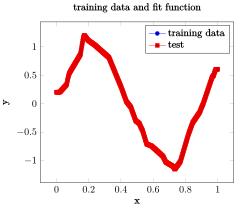

In [10]:
# part c: m = 200,stdev=2.0,eta = 0.001,numiter=1e5
a,b,w = init_params(200,2.0)
eta = 0.001
lambda = 0.0
numiter = 1e5
at,bt,wt = iterate(x,y,eta,a,b,w,numiter,lambda)
xtest = range(0,stop=1,length=400)
ytest = vec(fill(0.0,length(xtest)))
for i in 1:length(ytest)
    ytest[i] = f(xtest[i],at,bt,wt)
end
p_train = PGFPlots.Plots.Scatter(x,y,legendentry = "training data")
p_test = PGFPlots.Plots.Scatter(xtest,ytest,legendentry="test")
p = PGFPlots.Axis([p_train,p_test],xlabel="x",ylabel="y",title="training data and fit function")

In [17]:
JLD.save("c.jld","ytest",ytest,"at",at,"bt",bt,"wt",wt)

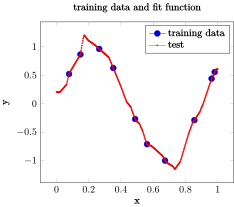

In [31]:
p_train = PGFPlots.Plots.Scatter(x,y,markSize=3,legendentry = "training data")
p_test = PGFPlots.Plots.Scatter(xtest,ytest,markSize=0.5,legendentry="test")
p = PGFPlots.Axis([p_train,p_test],xlabel="x",ylabel="y",title="training data and fit function")
display(p)
PGFPlots.save("figs/hw4/c.tikz",p)

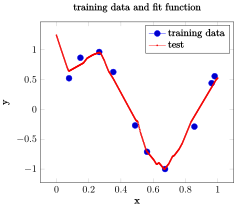

In [32]:
# part d: m = 200,stdev=2.0,eta = 0.001,numiter=1e5, lambda=0.005
a,b,w = init_params(200,2.0)
eta = 0.001
lambda = 0.005
numiter = 1e5
at,bt,wt = iterate(x,y,eta,a,b,w,numiter,lambda)
xtest = range(0,stop=1,length=400)
ytest = vec(fill(0.0,length(xtest)))
for i in 1:length(ytest)
    ytest[i] = f(xtest[i],at,bt,wt)
end
JLD.save("hw4_d.jld","ytest",ytest,"at",at,"bt",bt,"wt",wt)
p_train = PGFPlots.Plots.Scatter(x,y,markSize=3,legendentry = "training data")
p_test = PGFPlots.Plots.Scatter(xtest,ytest,markSize=0.5,legendentry="test")
p = PGFPlots.Axis([p_train,p_test],xlabel="x",ylabel="y",title="training data and fit function")
display(p)
PGFPlots.save("figs/hw4/d.tikz",p)

iternum=1000.0iternum=2000.0iternum=3000.0iternum=4000.0iternum=5000.0iternum=6000.0iternum=7000.0iternum=8000.0iternum=9000.0iternum=10000.0iternum=11000.0iternum=12000.0iternum=13000.0iternum=14000.0iternum=15000.0iternum=16000.0iternum=17000.0iternum=18000.0iternum=19000.0iternum=20000.0iternum=21000.0iternum=22000.0iternum=23000.0iternum=24000.0iternum=25000.0iternum=26000.0iternum=27000.0iternum=28000.0iternum=29000.0iternum=30000.0iternum=31000.0iternum=32000.0iternum=33000.0iternum=34000.0iternum=35000.0iternum=36000.0iternum=37000.0iternum=38000.0iternum=39000.0iternum=40000.0iternum=41000.0iternum=42000.0iternum=43000.0iternum=44000.0iternum=45000.0iternum=46000.0iternum=47000.0iternum=48000.0iternum=49000.0iternum=50000.0iternum=51000.0iternum=52000.0iternum=53000.0iternum=54000.0iternum=55000.0iternum=56000.0iternum=57000.0iternum=58000.0iternum=59000.0iternum=60000.0iternum=61000.0iternum=62000.0iternum=63000.0iternum=64000.0iternum=65000.0iternum=66000.0iternum=67000.0iter

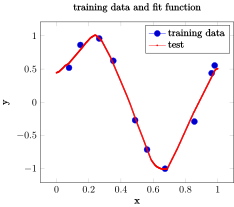

In [36]:
# part e: m = 200,stdev=1.0,eta = 0.001,numiter=1e5, lambda=0.0
a,b,w = init_params(200,1.0)
eta = 0.001
lambda = 0.0
numiter = 1e5
at,bt,wt = iterate(x,y,eta,a,b,w,numiter,lambda)
xtest = range(0,stop=1,length=400)
ytest = vec(fill(0.0,length(xtest)))
for i in 1:length(ytest)
    ytest[i] = f(xtest[i],at,bt,wt)
end
JLD.save("hw4_e.jld","ytest",ytest,"at",at,"bt",bt,"wt",wt)
p_train = PGFPlots.Plots.Scatter(x,y,markSize=3,legendentry = "training data")
p_test = PGFPlots.Plots.Scatter(xtest,ytest,markSize=0.5,legendentry="test")
p = PGFPlots.Axis([p_train,p_test],xlabel="x",ylabel="y",title="training data and fit function")
display(p)
PGFPlots.save("figs/hw4/e.tikz",p)

In [43]:
# function: Train network and fit function
function train_and_plot(x,y,m,stddev,eta,lambda,numiter;seed=1,filename="figs/output.tikz")
    Random.seed!(seed)
    a,b,w = init_params(m,stddev)
    at,bt,wt = iterate(x,y,eta,a,b,w,numiter,lambda)
    xtest = range(0,stop=1,length=400)
    ytest = vec(fill(0.0,length(xtest)))
    for i in 1:length(ytest)
        ytest[i] = f(xtest[i],at,bt,wt)
    end
    p_train = PGFPlots.Plots.Scatter(x,y,markSize=3,legendentry = "training data")
    p_test = PGFPlots.Plots.Scatter(xtest,ytest,markSize=0.5,legendentry="test")
    p = PGFPlots.Axis([p_train,p_test],xlabel="x",ylabel="y",title="training data and fit function")
    display(p)
    PGFPlots.save(filename,p)
    return nothing
end

train_and_plot (generic function with 1 method)

iternum=1000.0iternum=2000.0iternum=3000.0iternum=4000.0iternum=5000.0iternum=6000.0iternum=7000.0iternum=8000.0iternum=9000.0iternum=10000.0iternum=11000.0iternum=12000.0iternum=13000.0iternum=14000.0iternum=15000.0iternum=16000.0iternum=17000.0iternum=18000.0iternum=19000.0iternum=20000.0iternum=21000.0iternum=22000.0iternum=23000.0iternum=24000.0iternum=25000.0iternum=26000.0iternum=27000.0iternum=28000.0iternum=29000.0iternum=30000.0iternum=31000.0iternum=32000.0iternum=33000.0iternum=34000.0iternum=35000.0iternum=36000.0iternum=37000.0iternum=38000.0iternum=39000.0iternum=40000.0iternum=41000.0iternum=42000.0iternum=43000.0iternum=44000.0iternum=45000.0iternum=46000.0iternum=47000.0iternum=48000.0iternum=49000.0iternum=50000.0iternum=51000.0iternum=52000.0iternum=53000.0iternum=54000.0iternum=55000.0iternum=56000.0iternum=57000.0iternum=58000.0iternum=59000.0iternum=60000.0iternum=61000.0iternum=62000.0iternum=63000.0iternum=64000.0iternum=65000.0iternum=66000.0iternum=67000.0iter

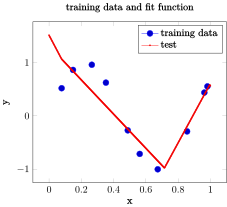

In [44]:
train_and_plot(x,y,10,1,0.01,0,1e5,seed=5,filename="figs/hw4/b.tikz")